<img  src="https://www.bcm.edu/themes/custom/bcm_bootstrap_subtheme/css/../images/BCM-90x90.svg" alt="Drawing" style="height: 100px;float: left;"/>

# Real-time $R_t$ of COVID-19 pandemic in Texas (Until Oct 01)

This report estimates the county level real-time effective production number ($R_t$) of the COVID-19 pandemic in Texas, based on data from 
[the Texas Health and Human Services](https://www.dshs.state.tx.us/coronavirus/). This report is updated daily with the most recent version available at the ICTR website.

This report is created and maintained by data scientists
from the [Institute for Clinical & Translational Research, Baylor College of Medicine](https://www.bcm.edu/research/research-offices/institute-for-clinical-translational-research), with an algorithm that is based on [Kevin Systrom's work](https://github.com/k-sys/covid-19) for the US data. Please refer to the original report for details.

In [1]:
param_days = 10
param_std = 2.3
param_sigma = 0.10

In [2]:
%put param_days param_std param_sigma --to Python3
# Parameters
param_days = 10
param_std = 2.2
param_sigma = 0.08


UsageError: Line magic function `%put` not found.


In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = [] #'AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

In [4]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
#print(y.shape)

In [5]:
k = 20

lam = np.linspace(1, 45, 90)

In [6]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

In [7]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

In [8]:
most_likely_values = posteriors.idxmax(axis=0)

In [9]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)

In [10]:
url = '../covid-19-county-R0/TSHS_CaseCountData/covid_19_positive.txt'
counties = pd.read_csv(url,
                     usecols=['date', 'county', 'positive'],
                     parse_dates=['date'],
                     index_col=['county', 'date'],
                     squeeze=True, sep="\t").sort_index()

In [11]:
county_name = 'Harris'

def prepare_cases(cases, cutoff=24, smooth_days=7, smooth_std=2):
    new_cases = cases.diff()
    
    smoothed = new_cases.rolling(smooth_days,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=smooth_std).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def plot_cases(county_name, ax, cutoff=1):
    cases = counties.xs(county_name).rename(f"{county_name} cases")
    original, smoothed = prepare_cases(cases, cutoff=cutoff)
    
    index = original.index.get_level_values('date')
    values = original.values
    ax.plot(index, values, 
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual')
    ax.set_title(f"{county_name} New Cases per Day")
    index = smoothed.index.get_level_values('date')
    values = smoothed.values
    ax.scatter(index, values, label='Smoothed', lw=0.3, s=20)
    ax.get_figure().set_facecolor('w')
    #ax.set_xticklabels(, rotation=45, ha='right')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())    
    ax.set_xlim(pd.Timestamp('2020-03-01'), original.index.get_level_values('date')[-1]+pd.Timedelta(days=1))

    
#county_name = 'Brewster'
cases = counties.xs(county_name).rename(f"{county_name} cases")
original, smoothed = prepare_cases(cases)
#fig, ax = plt.subplots(figsize=(600/72,400/72))
#plot_cases(county_name, ax)

In [12]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

In [13]:
county_name = 'Harris'
#ax = posteriors.plot(title=f'{county_name} - Daily Posterior for $R_t$',
#           legend=False, 
#           lw=1,
#           c='k',
#           alpha=.3,
#           xlim=(0.4,6))

#ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [14]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

In [15]:
#result.tail(n=15)

In [16]:
def plot_rt(result, ax, county_name):
    
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    ax.set_title(f'{county_name} Real Time Rt ({values[-1]:.1f} on {result.index.get_level_values("date")[-1].strftime("%m/%d")})')
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
#fig, ax = plt.subplots(figsize=(600/72,400/72))

#plot_rt(result, ax, county_name)
#ax.set_title(f'Real-time $R_t$ for {county_name} (till {result.index.get_level_values("date")[-1].strftime("%m/%d")})')
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#plt.xticks(rotation=45)


In [17]:
targets = ~counties.index.get_level_values('county').isin(FILTERED_REGION_CODES)

In [18]:
counties_to_process = counties.loc[targets]

In [19]:
counties_to_process

county    date      
Anderson  2020-03-05      0
          2020-03-06      0
          2020-03-09      0
          2020-03-10      0
          2020-03-11      0
                       ... 
Zavala    2020-09-26    357
          2020-09-27    357
          2020-09-28    372
          2020-09-29    365
          2020-09-30    369
Name: positive, Length: 52578, dtype: int64

In [20]:
import sys
#sys.getrecursionlimit()

In [21]:
sys.setrecursionlimit(10000)

In [22]:
sigmas = np.linspace(1/20, 1, 20)

targets = ~counties.index.get_level_values('county').isin(FILTERED_REGION_CODES)
counties_to_process = counties.loc[targets]

results = {}

for county_name, cases in counties_to_process.groupby(level='county'):
    
    print(county_name)
#(county_name == "Coryell")|(county_name == "Jones")|(county_name == "Moore")|(county_name == "Panola")|(county_name == "Taylor"):
    if (county_name == "Bowie")|(county_name == "Coryell")|(county_name == "Harrison")|(county_name == "Houston")|(county_name == "Jones")|(county_name == "Panola")|(county_name == "Pecos")|(county_name == "Taylor"):
        continue
        
    new, smoothed = prepare_cases(cases, cutoff=1)
      
    max_cases = smoothed.max()
    if np.isnan(max_cases) or max_cases <= 2:
        continue
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=1)
    if len(smoothed) == 0:
        continue
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of county name
    results[county_name] = result
    clear_output(wait=True)

print('Done.')

Done.


In [23]:
len(results)

191

Now that we have all the log likelihoods, we can sum for each value of sigma across counties, graph it, then choose the maximum.

In [24]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each county's results and add the log likelihoods to the running total.
for county_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
#fig, ax = plt.subplots()
#ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
#ax.plot(sigmas, total_log_likelihoods)
#ax.axvline(sigma, color='k', linestyle=":")

### Compile Final Results

Given that we've selected the optimal $\sigma$, let's grab the precalculated posterior corresponding to that value of $\sigma$ for each county. Let's also calculate the 90% and 50% highest density intervals (this takes a little while) and also the most likely value.

In [25]:
#del results["CT"]

In [26]:
final_results = None

for county_name, result in results.items():
    print(county_name)
    posteriors = result['posteriors'][max_likelihood_index]
    try:
        hdis_90 = highest_density_interval(posteriors, p=.9)
        hdis_50 = highest_density_interval(posteriors, p=.5)
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    except:
        print(f'Not enough data is available for {county_name}')
        continue
    if result is not None:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Young
Not enough data is available for Young
Zapata


Not enough data is available for Zapata
Zavala


Not enough data is available for Zavala
Done.


## Daily new cases and real time $R_t$ for Texas Medical Center

In [27]:
# find the latest data automatically
import os
latest_data = sorted([x for x in os.listdir('TMC') if x.startswith('Total Tests') and x.endswith('xlsx')])[-1]
tmc_data = pd.read_excel(f'TMC/{latest_data}')
tmc_data = tmc_data.dropna()
tmc_data = tmc_data[tmc_data["Collected Date"] != "Grand Total"]
tmc_data['Collected Date']= pd.to_datetime(tmc_data['Collected Date']) 
tmc_data = tmc_data.sort_values(by='Collected Date').set_index('Collected Date')
tmc_cases = tmc_data['POSITIVE'].cumsum()

In [28]:

def plot_tmc_cases(cases, ax, cutoff=15, smooth_days=7, smooth_std=2):
    original, smoothed = prepare_cases(cases, cutoff=cutoff, smooth_days=smooth_days,
                                           smooth_std=smooth_std)
    
    index = original.index.get_level_values('Collected Date')
    values = original.values
    ax.plot(index, values, 
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual')
    ax.set_title(f"TMC New Cases per Day")
    index = smoothed.index.get_level_values('Collected Date')
    values = smoothed.values
    ax.scatter(index, values, label='Smoothed', lw=0.3, s=20)
    ax.get_figure().set_facecolor('w')
    #ax.set_xticklabels(, rotation=45, ha='right')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())    
    ax.set_xlim(pd.Timestamp('2020-03-01'), original.index.get_level_values('Collected Date')[-1]+pd.Timedelta(days=1))
    
    
def plot_tmc_rt(result, ax):
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Collected Date')
    values = result['ML'].values
    ax.set_title(f'TMC Real Time Rt ({values[-1]:.1f} on {result.index.get_level_values("Collected Date")[-1].strftime("%m/%d")})')
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), 
                result.index.get_level_values('Collected Date')[-1] + pd.Timedelta(days=1))
    fig.set_facecolor('w')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


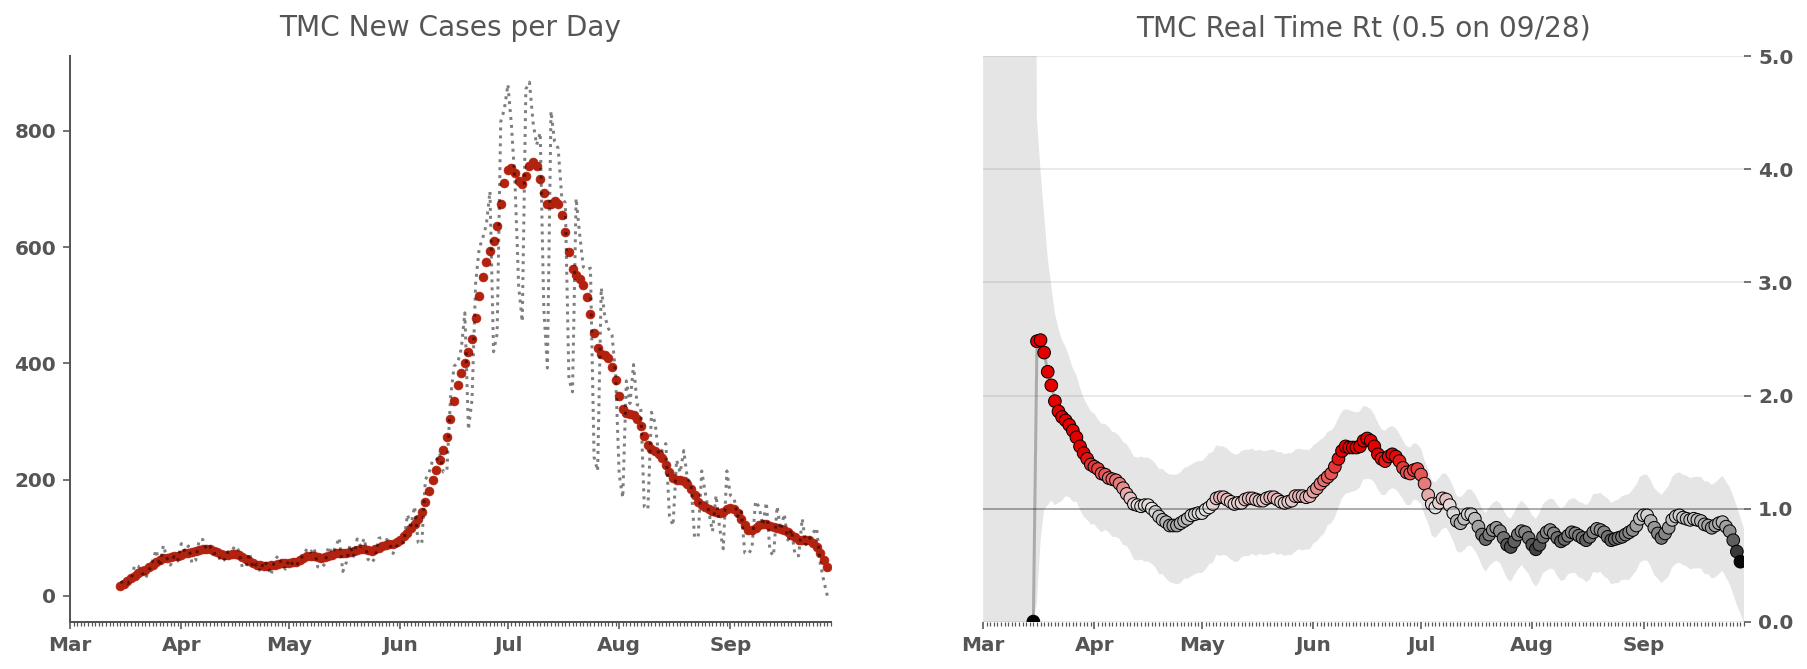

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

tmc_original, tmc_smoothed = prepare_cases(tmc_cases, cutoff=14, smooth_days=param_days, smooth_std=param_std)
plot_tmc_cases(tmc_cases, axes[0], smooth_days=param_days, smooth_std=param_std)

tmc_posteriors, tmc_log_likelihood = get_posteriors(tmc_smoothed, sigma=param_sigma)
tmc_hdis = highest_density_interval(tmc_posteriors, p=.9)

tmc_most_likely = tmc_posteriors.idxmax().rename('ML')

# Look into why you shift -1
tmc_result = pd.concat([tmc_most_likely, tmc_hdis], axis=1)
plot_tmc_rt(tmc_result, axes[1])


Here are estimated $R_t$ in the past 15 days:

In [30]:
tmc_result.tail(n=15)

ML  Low_90  High_90
Collected Date                       
2020-09-14      0.90    0.46     1.27
2020-09-15      0.91    0.47     1.28
2020-09-16      0.90    0.47     1.28
2020-09-17      0.89    0.47     1.28
2020-09-18      0.86    0.42     1.24
2020-09-19      0.85    0.42     1.24
2020-09-20      0.83    0.38     1.21
2020-09-21      0.85    0.39     1.23
2020-09-22      0.87    0.42     1.26
2020-09-23      0.88    0.45     1.29
2020-09-24      0.84    0.39     1.24
2020-09-25      0.80    0.33     1.19
2020-09-26      0.72    0.24     1.11
2020-09-27      0.62    0.15     1.02
2020-09-28      0.53    0.07     0.92

## Daily new cases and real time $R_t$ for Harris County

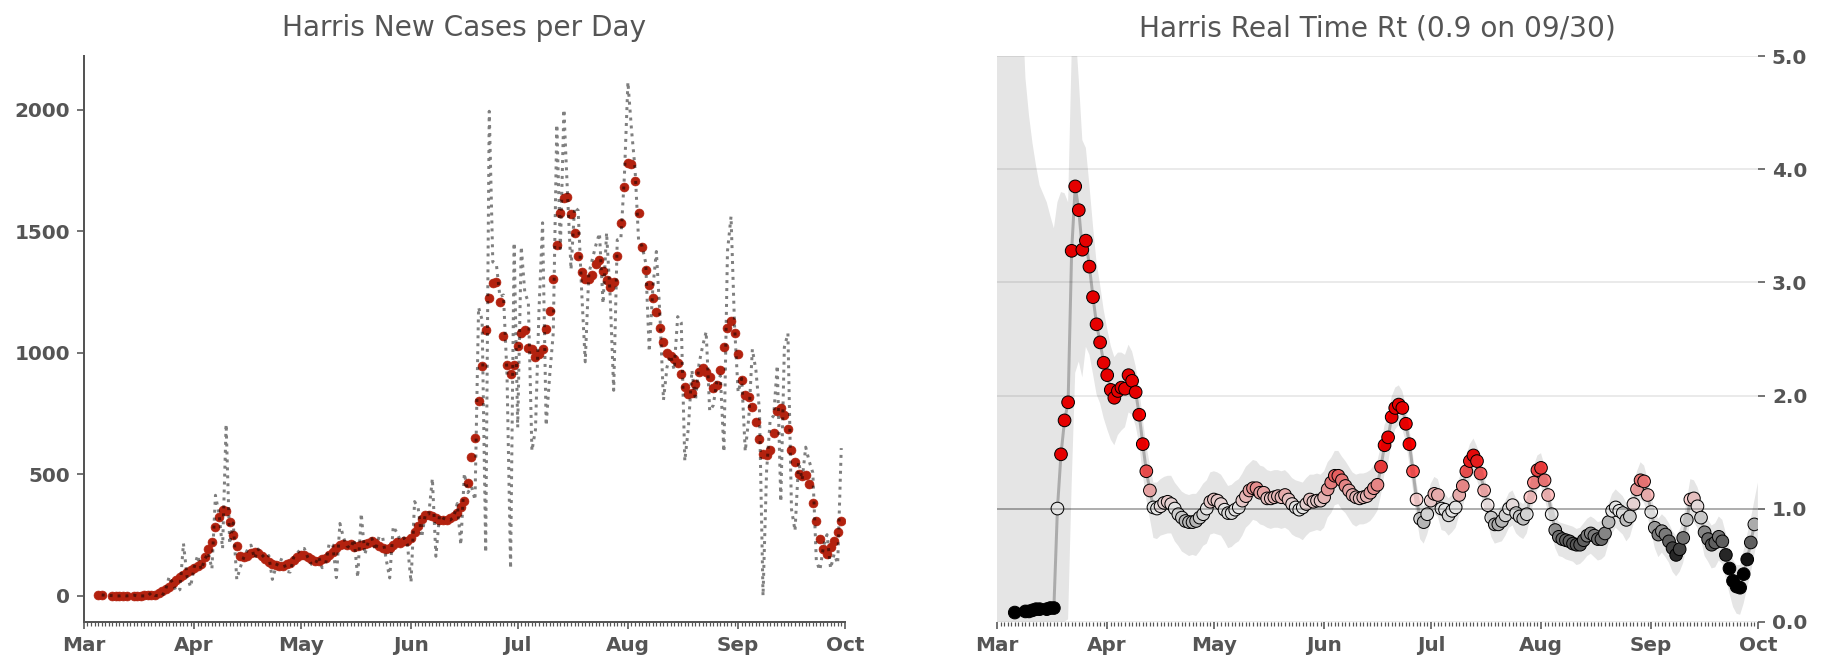

In [31]:
county_name = 'Harris'
harris_result = [result for name, result in final_results.groupby('county')
    if name == county_name][0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plot_cases(county_name, axes.flat[0], cutoff=1)
plot_rt(harris_result.iloc[1:], axes.flat[1], county_name) 
plt.show()

Here are estimated $R_t$ in the past 15 days:

In [32]:
harris_result.tail(15)

ML  Low_90  High_90  Low_50  High_50
county date                                              
Harris 2020-09-16  0.79    0.58     0.95    0.70     0.85
       2020-09-17  0.73    0.53     0.90    0.61     0.77
       2020-09-18  0.68    0.47     0.85    0.57     0.73
       2020-09-19  0.70    0.48     0.87    0.60     0.76
       2020-09-20  0.75    0.54     0.93    0.65     0.81
       2020-09-21  0.71    0.51     0.90    0.63     0.79
       2020-09-22  0.59    0.38     0.78    0.47     0.64
       2020-09-23  0.47    0.25     0.66    0.36     0.53
       2020-09-24  0.36    0.13     0.55    0.23     0.41
       2020-09-25  0.31    0.07     0.50    0.19     0.37
       2020-09-26  0.30    0.06     0.50    0.16     0.35
       2020-09-27  0.42    0.16     0.63    0.31     0.50
       2020-09-28  0.55    0.30     0.77    0.41     0.61
       2020-09-29  0.70    0.43     0.91    0.56     0.76
       2020-09-30  0.86    0.59     1.07    0.72     0.92

## Daily new cases and real time $R_t$ for all Texas counties

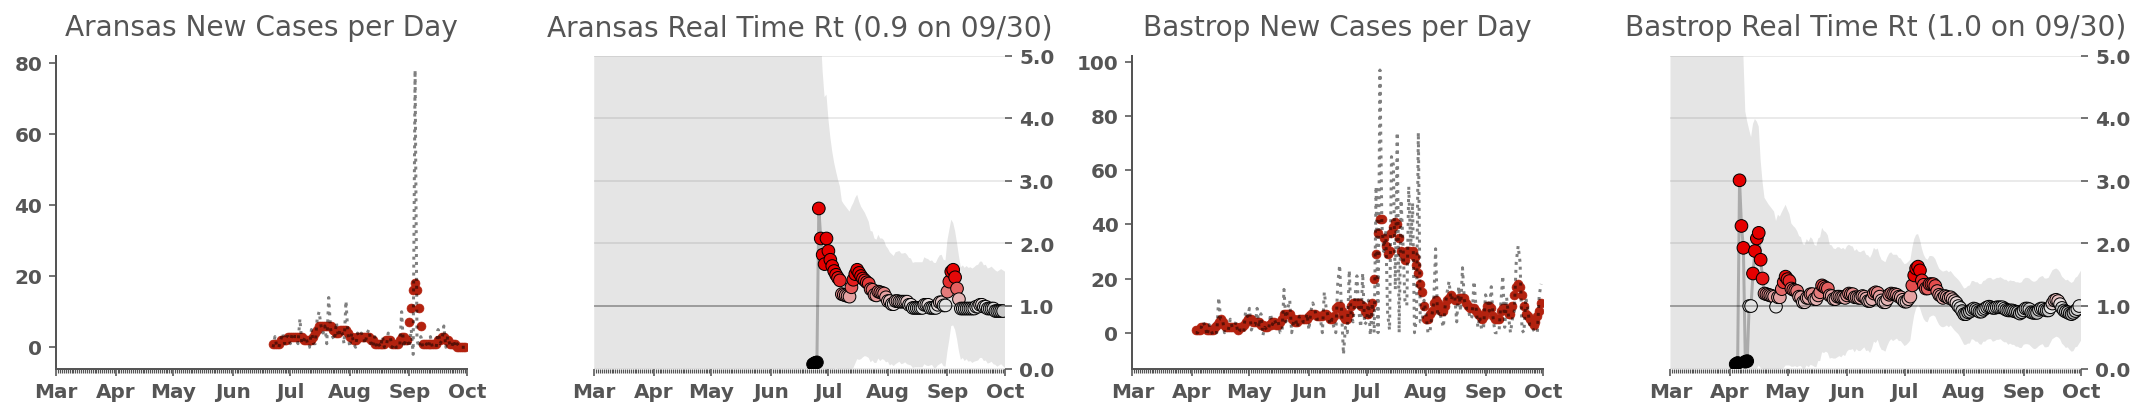

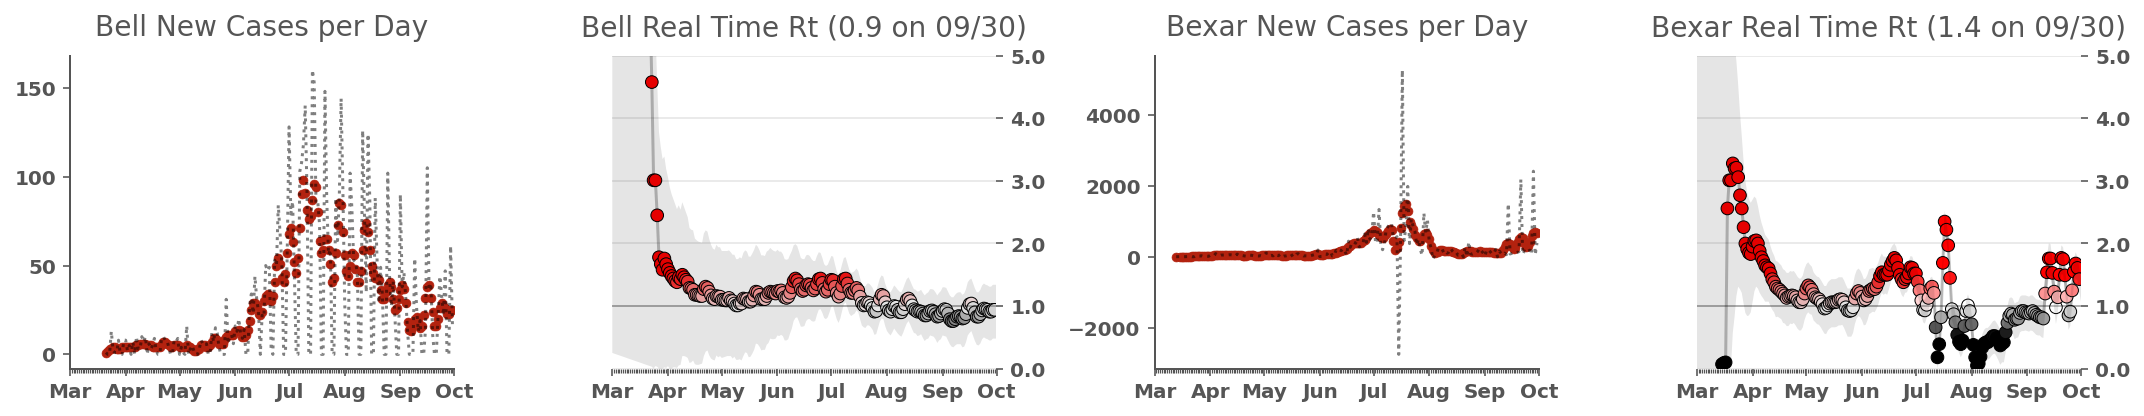

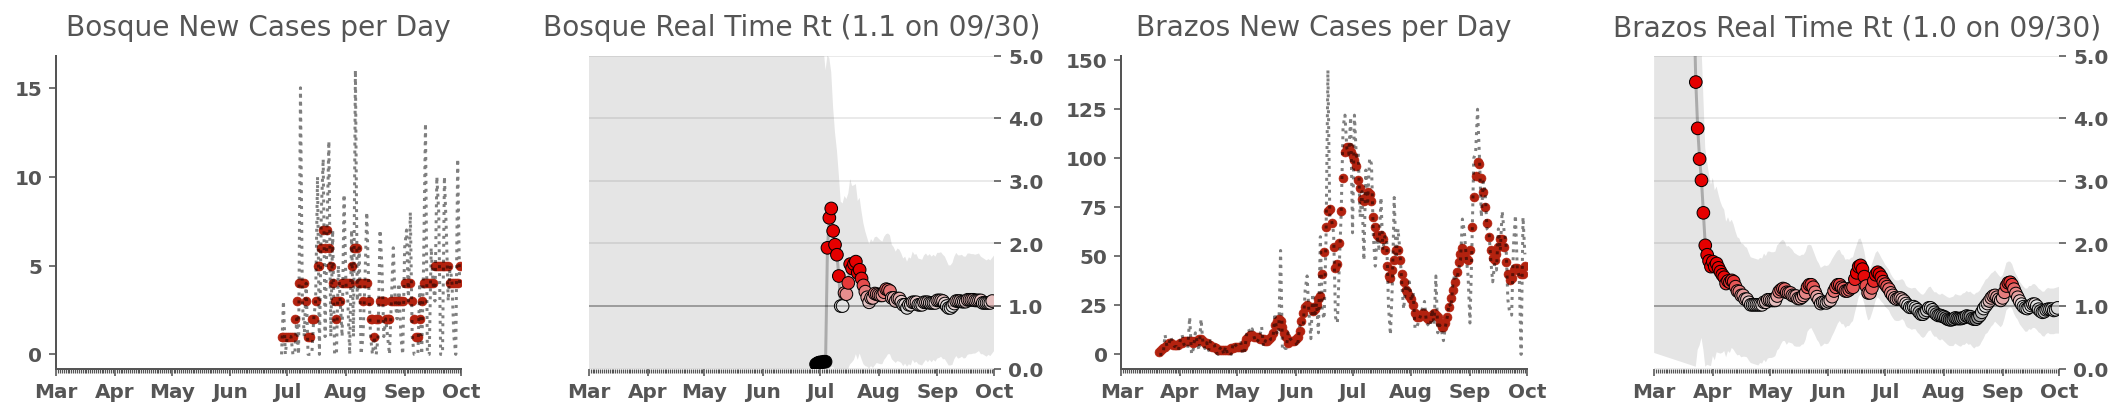

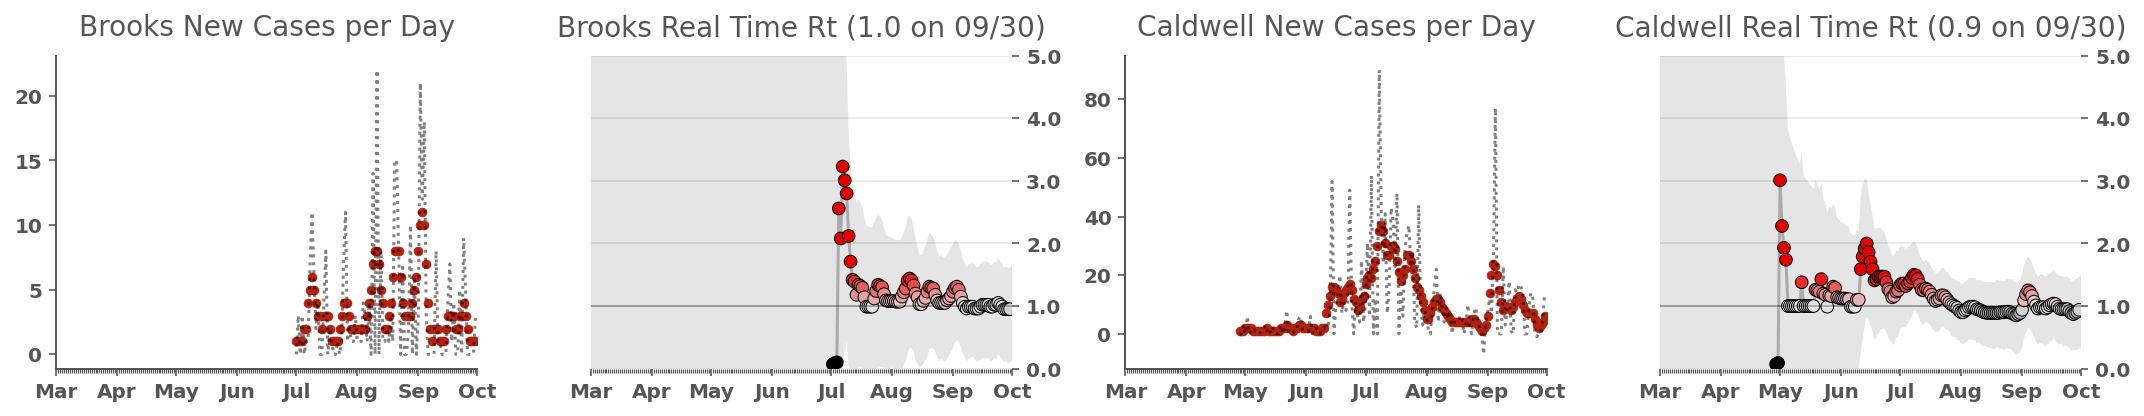

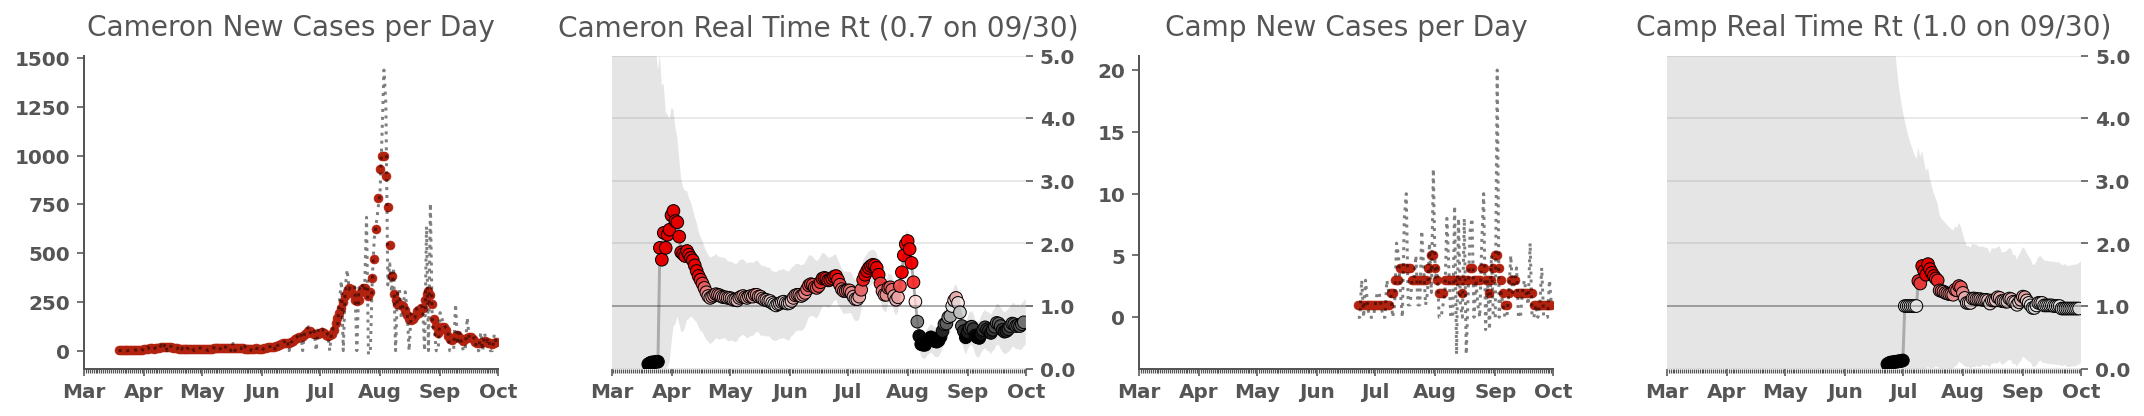

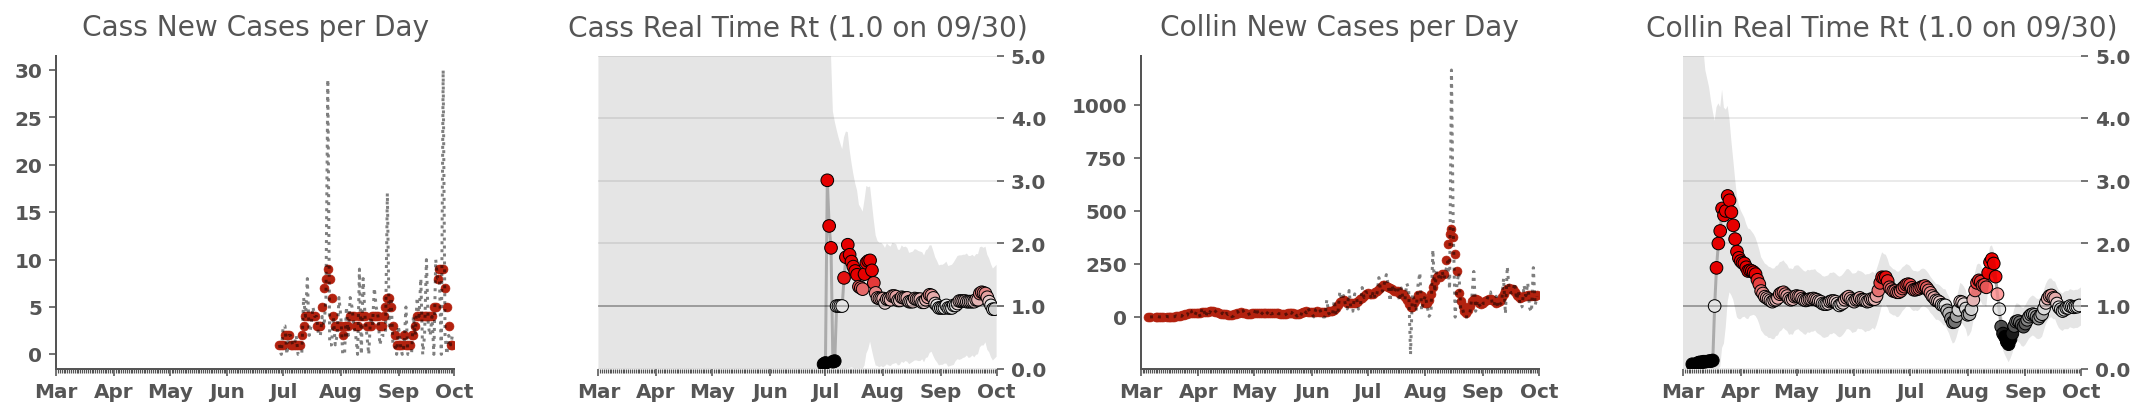

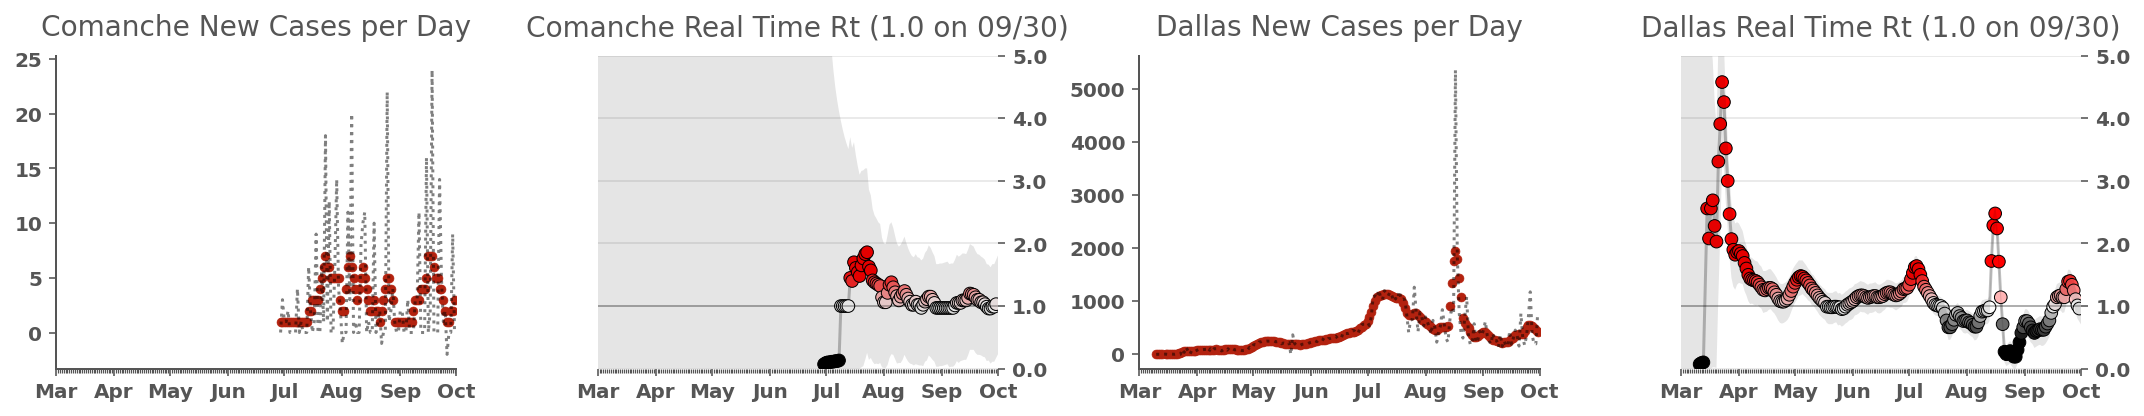

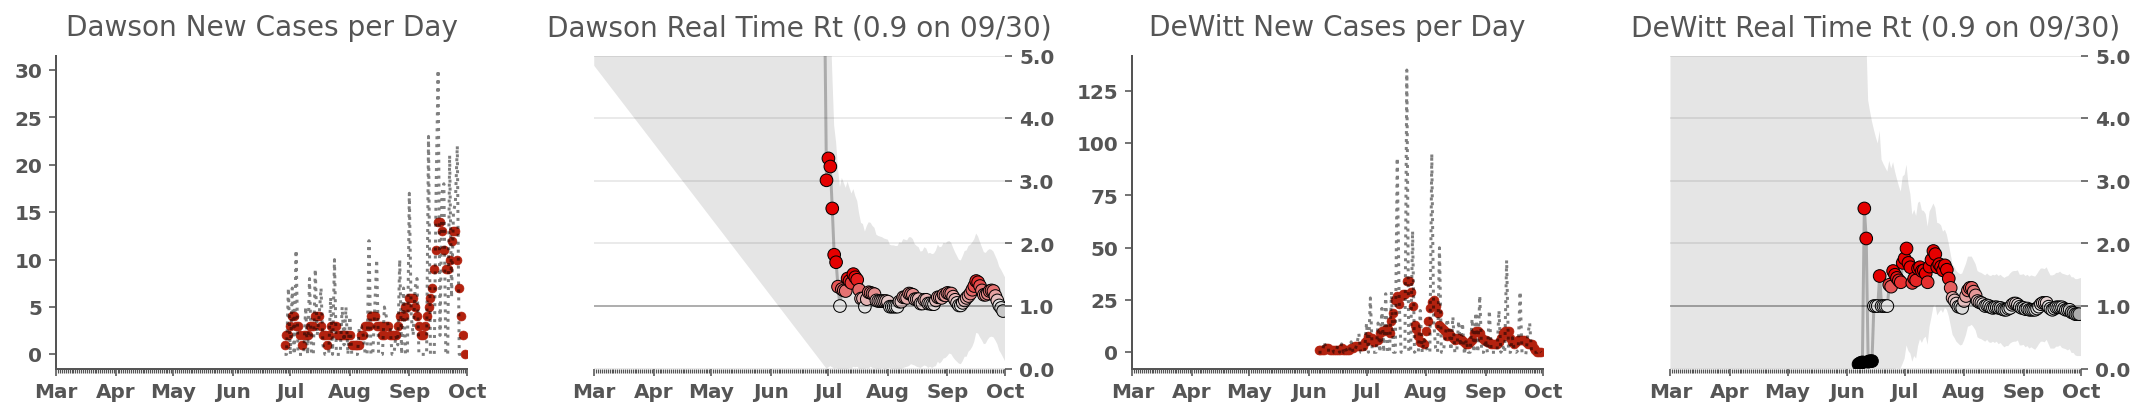

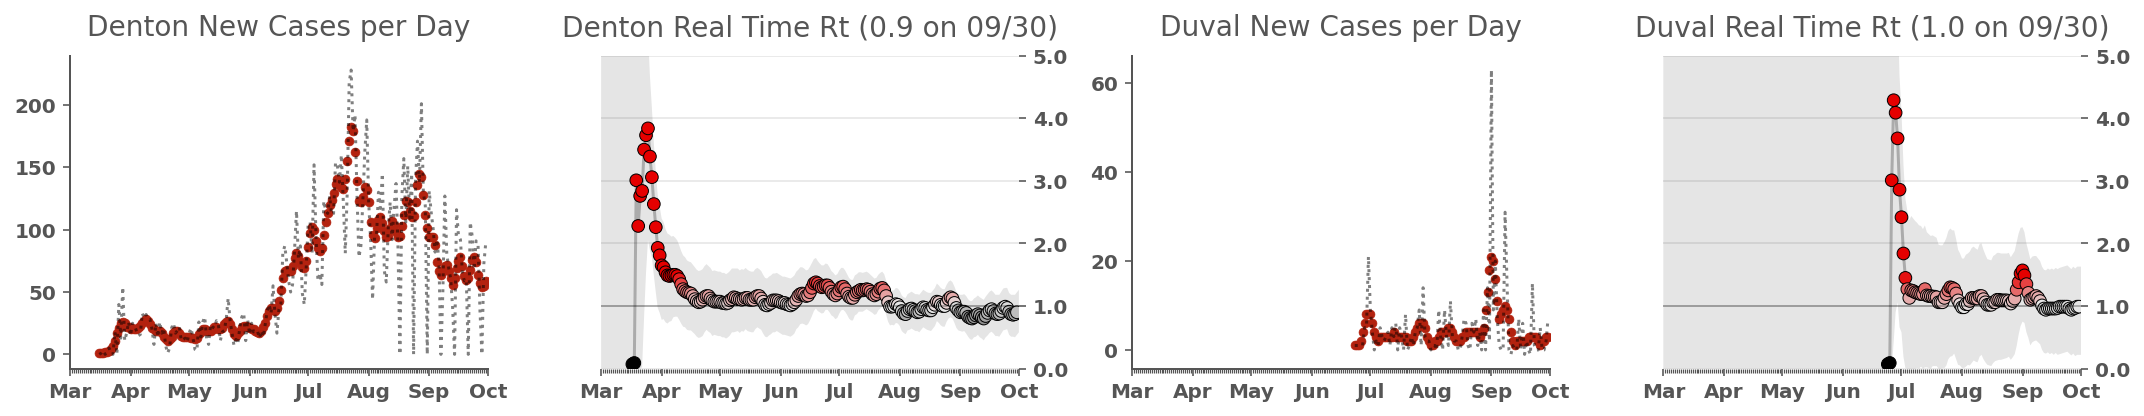

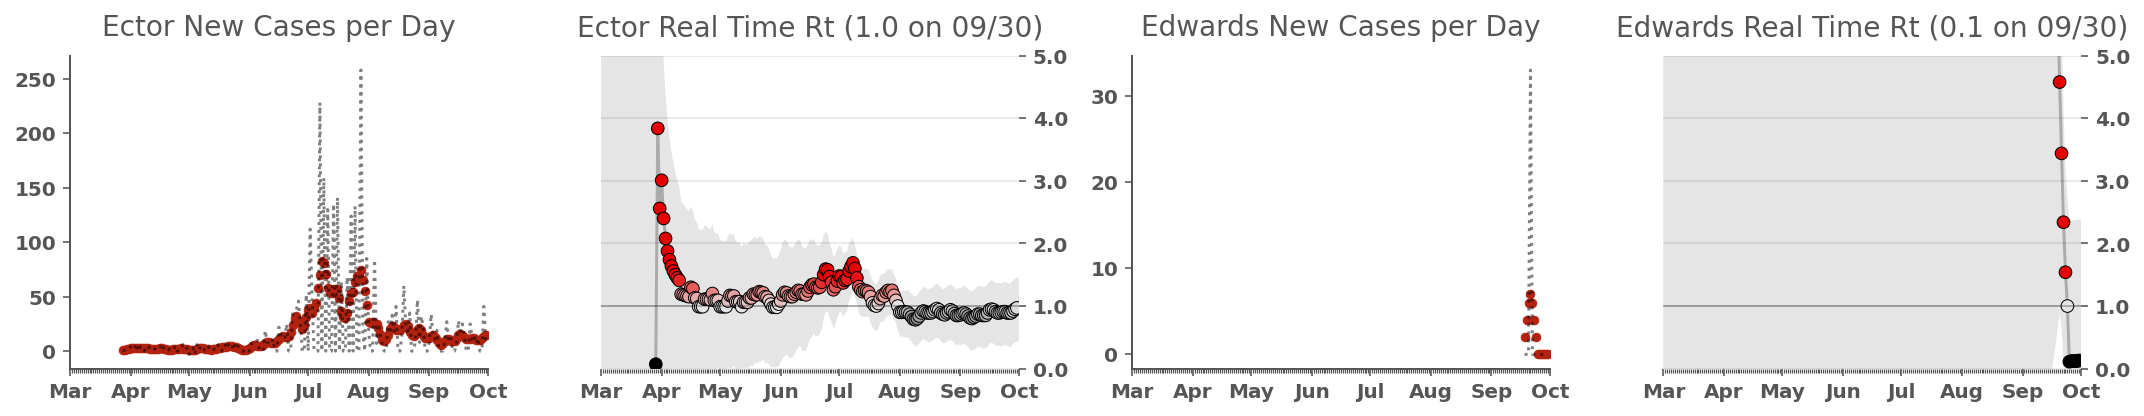

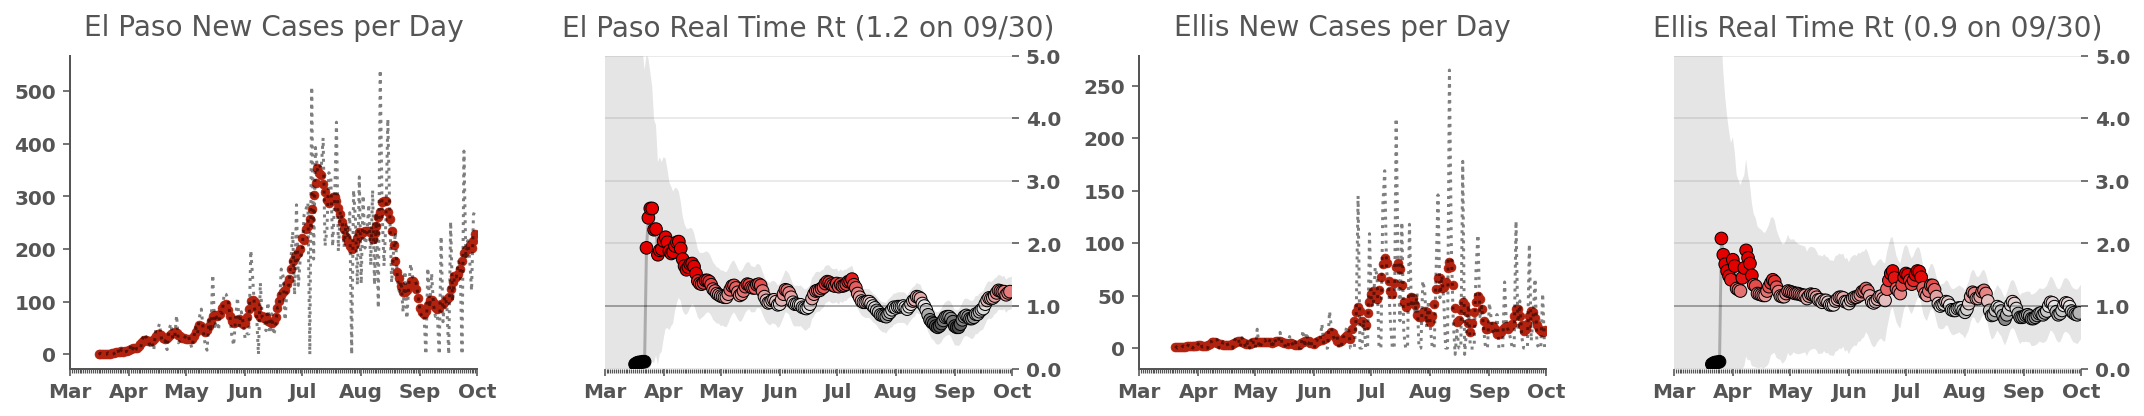

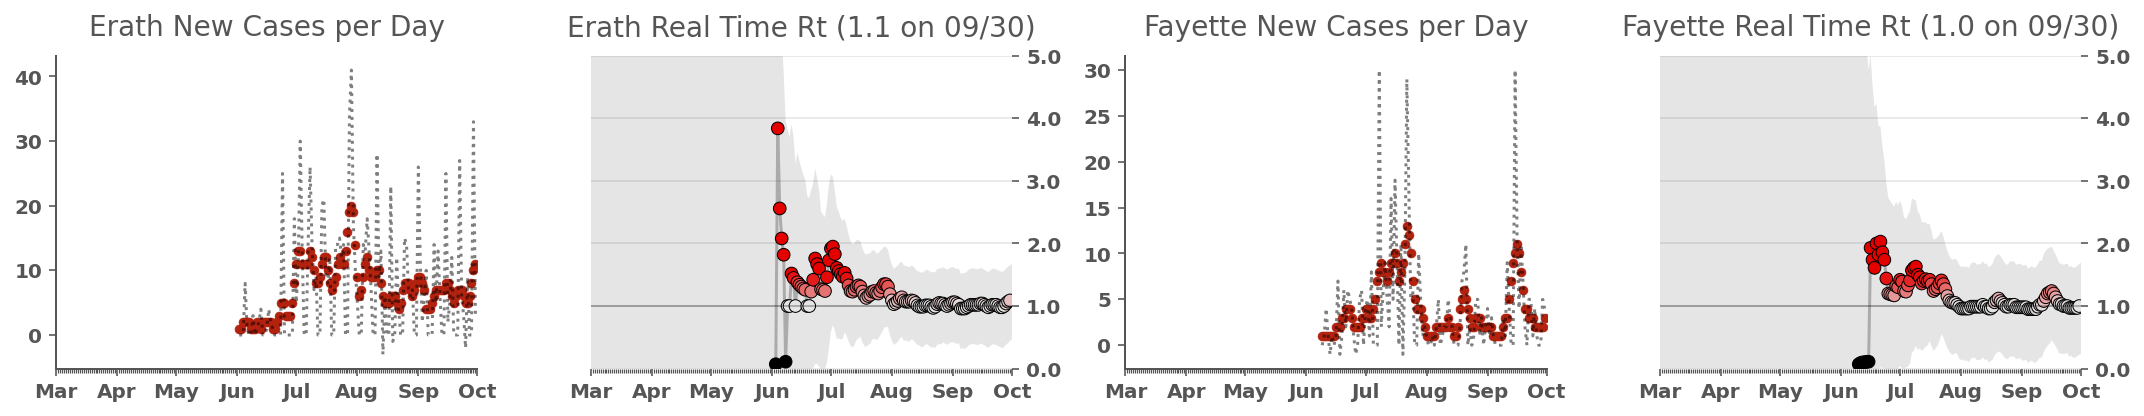

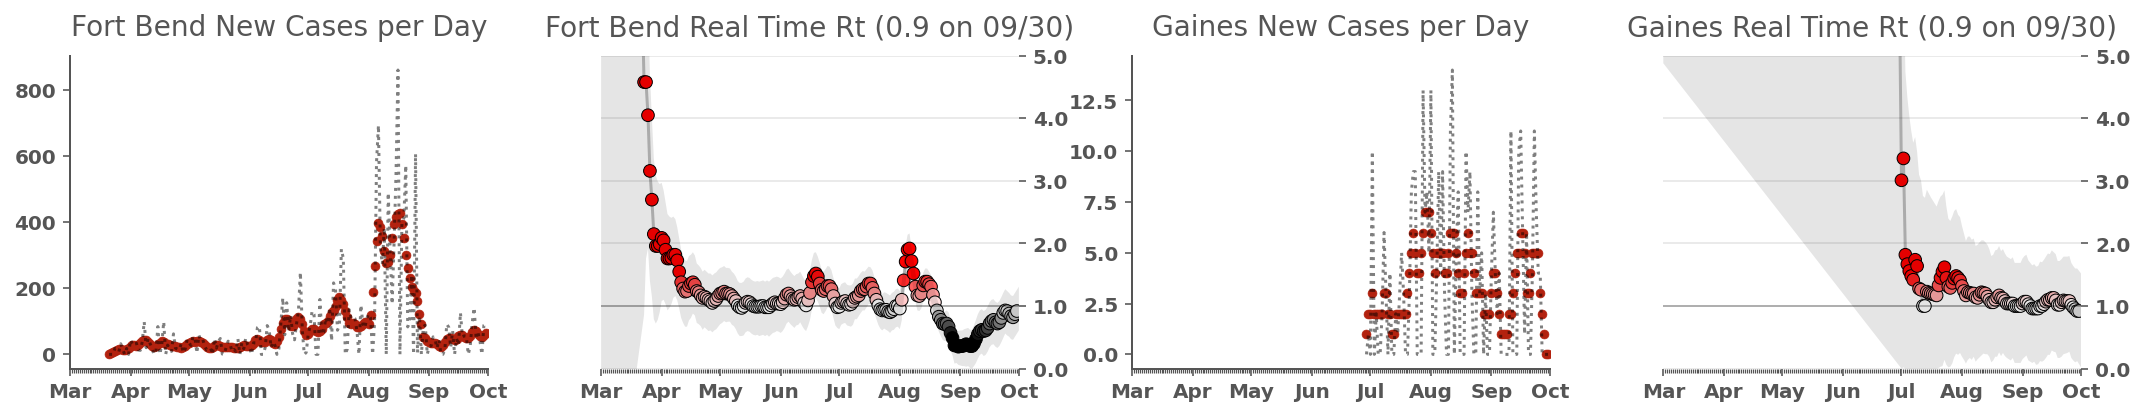

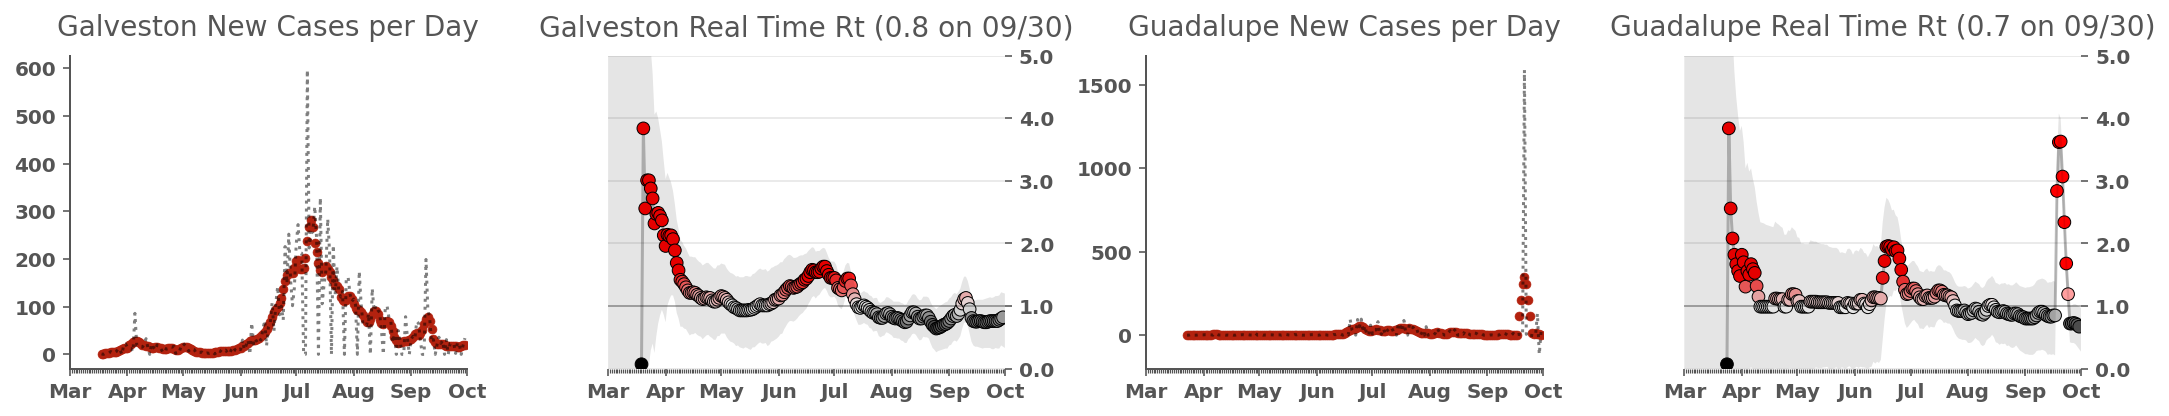

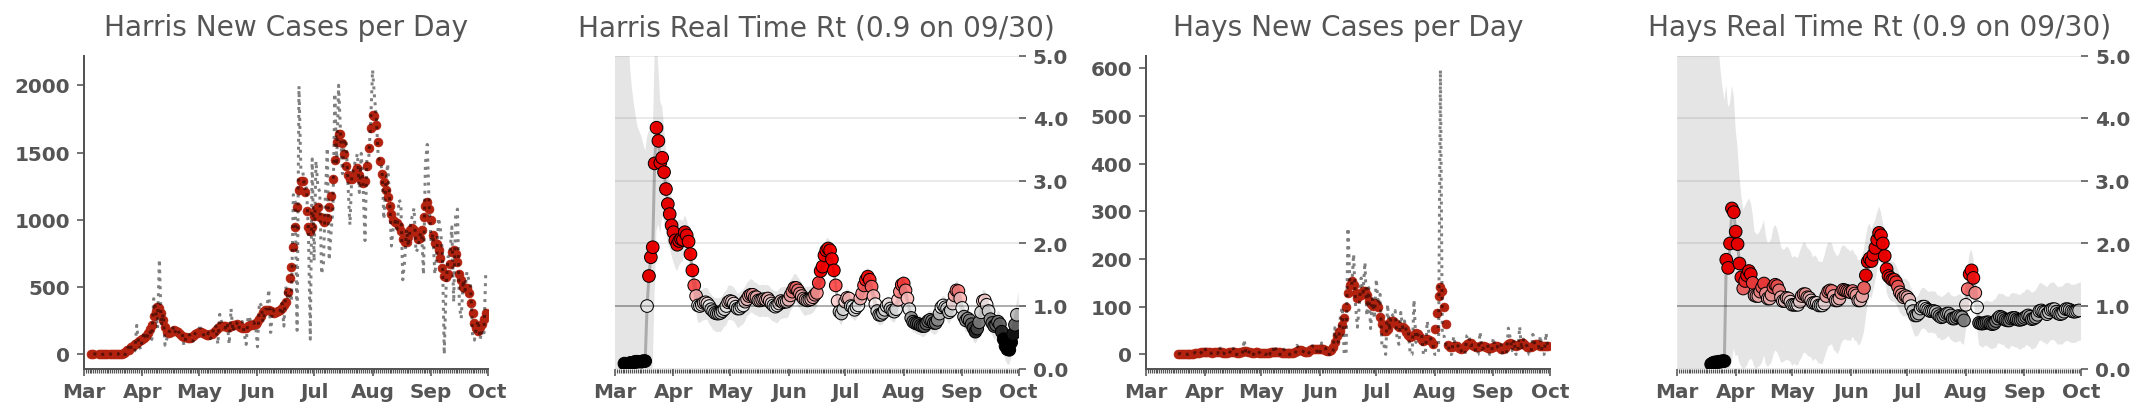

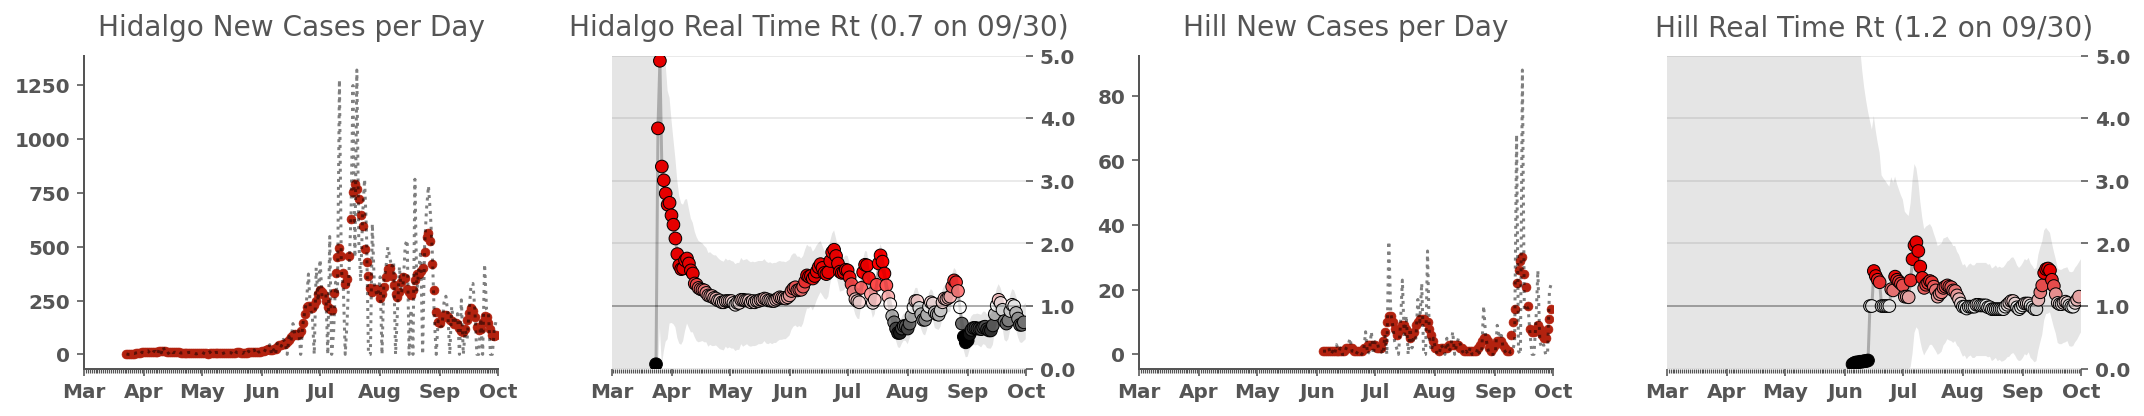

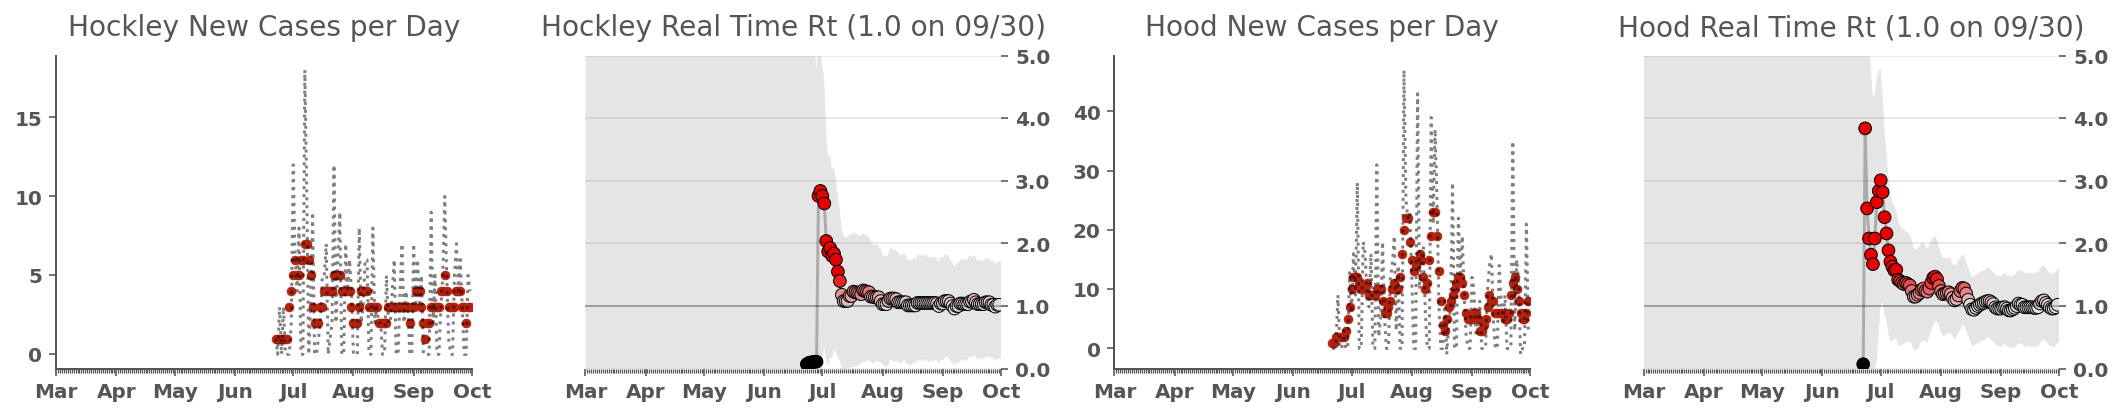

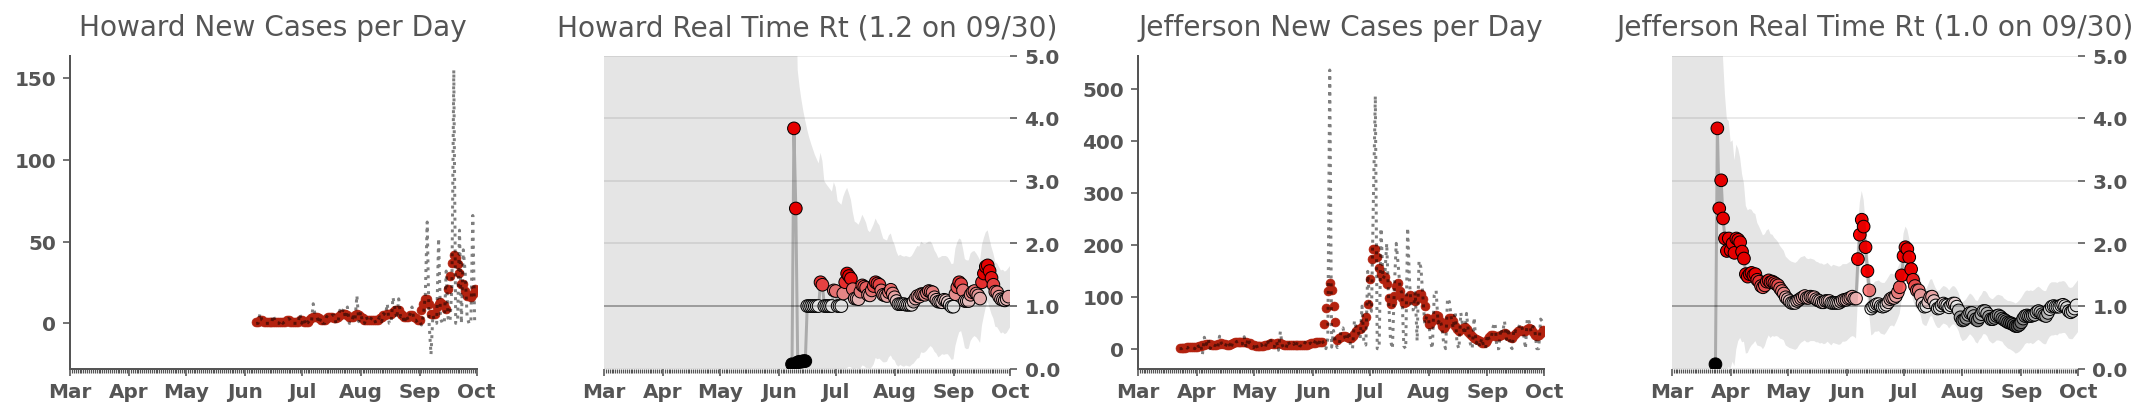

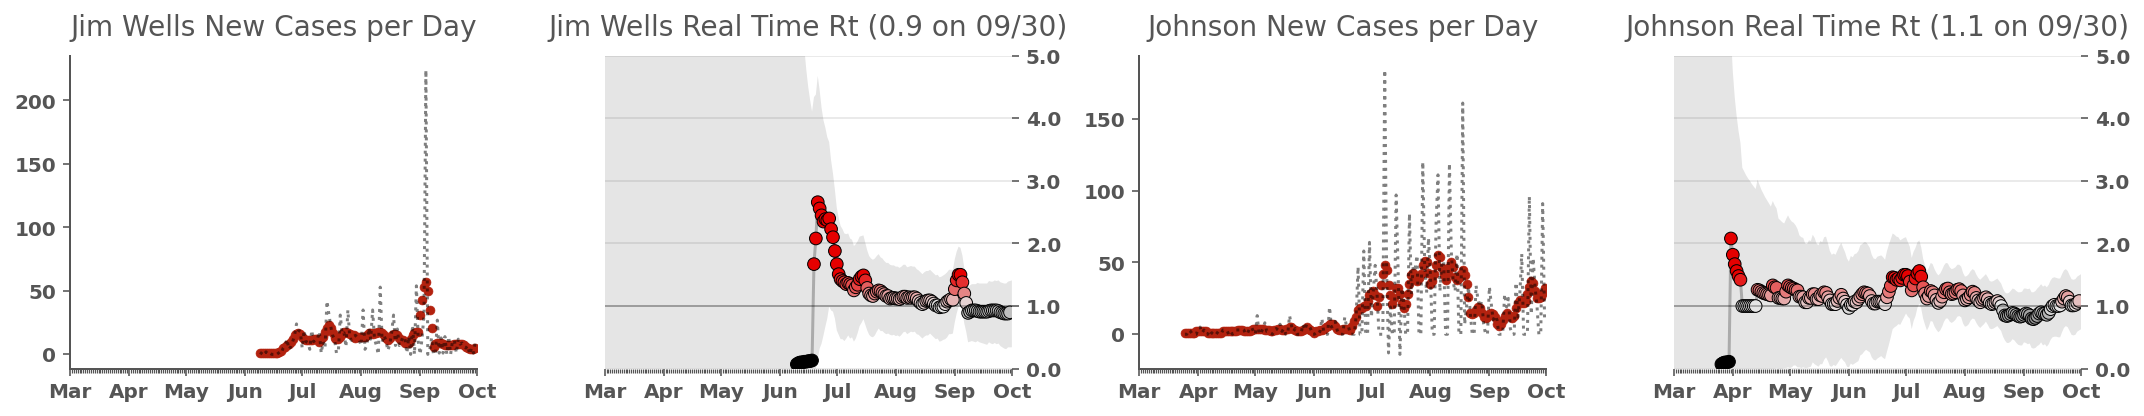

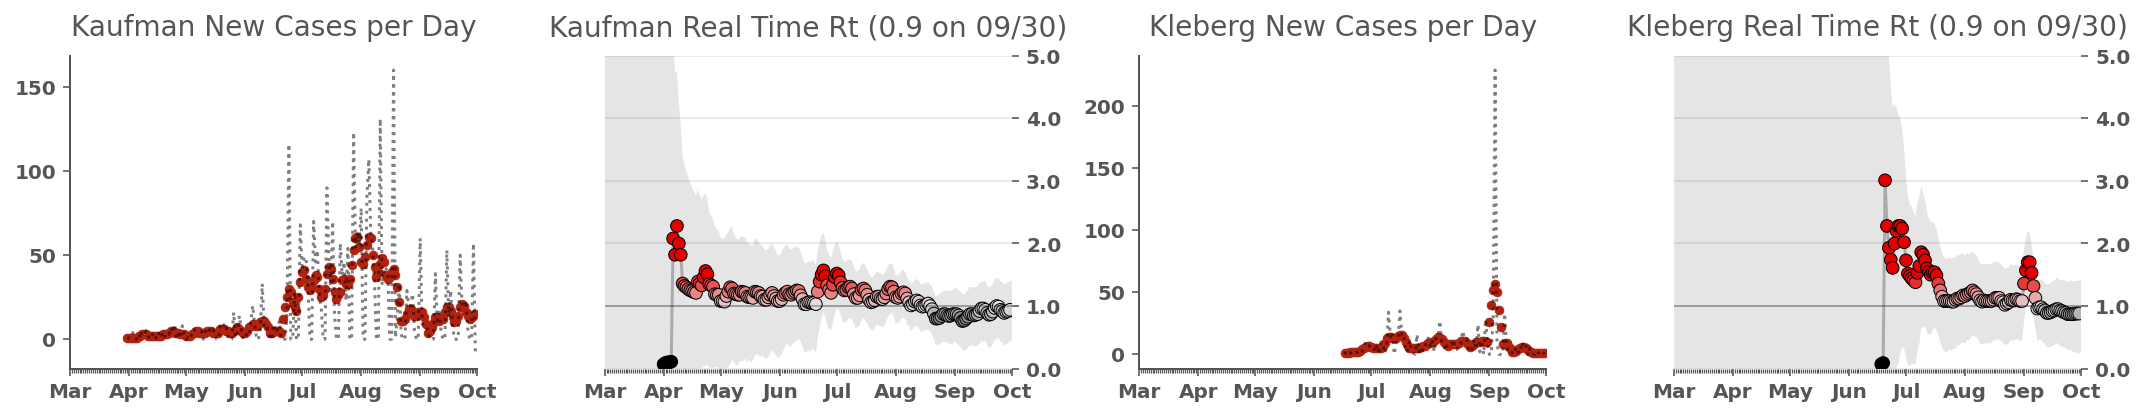

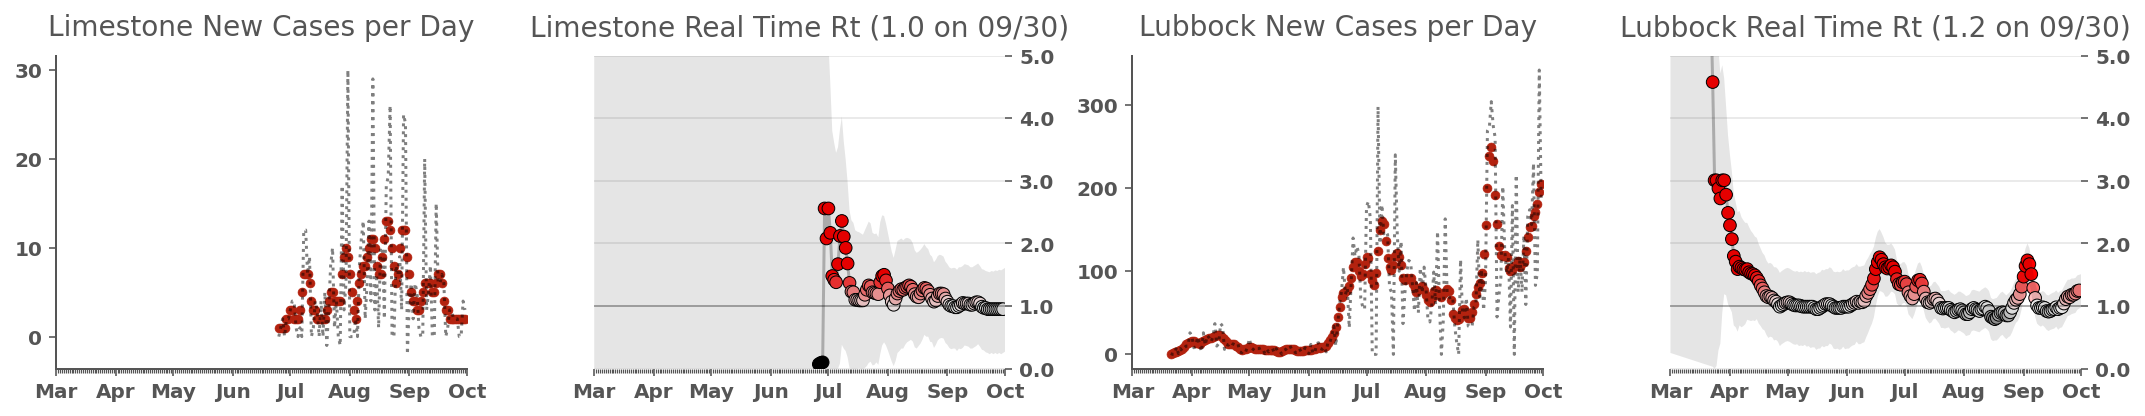

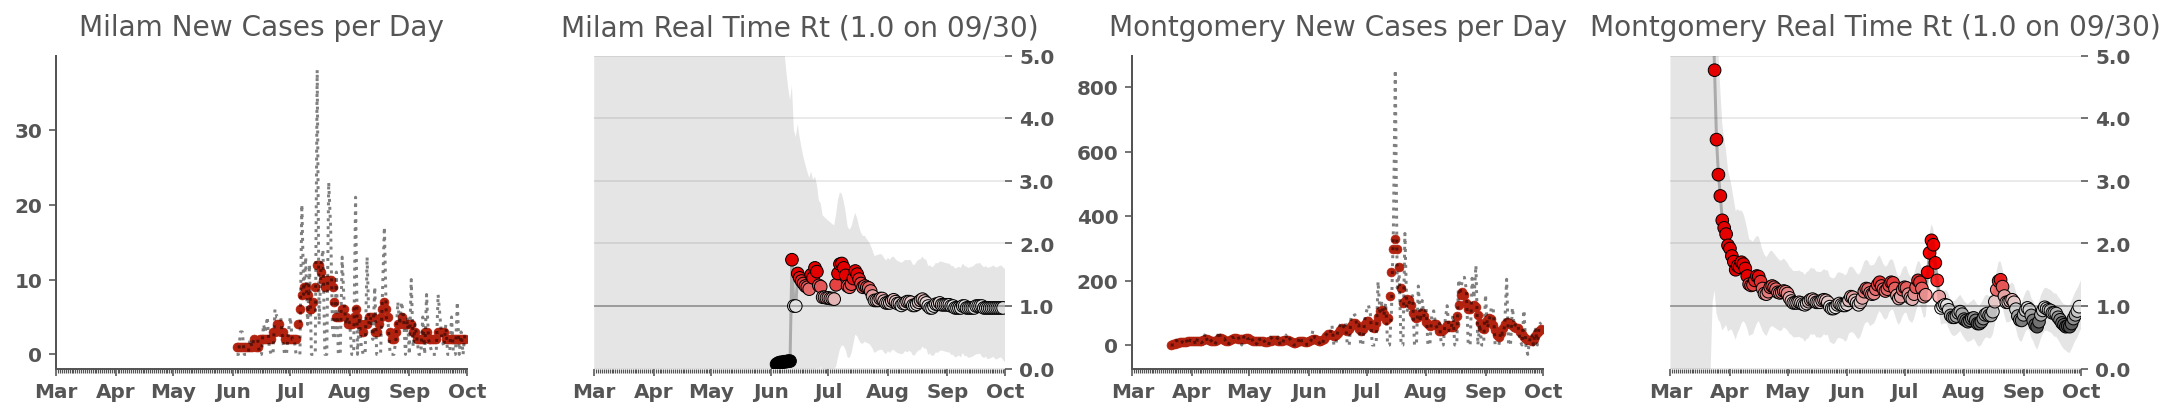

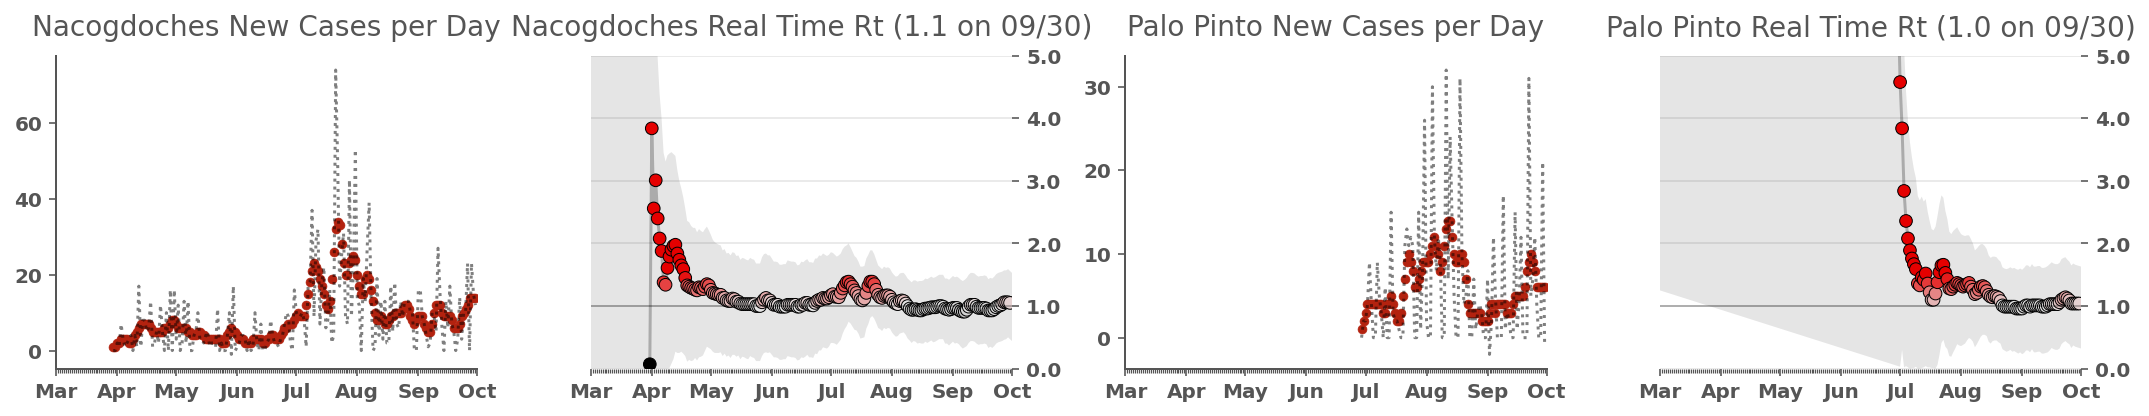

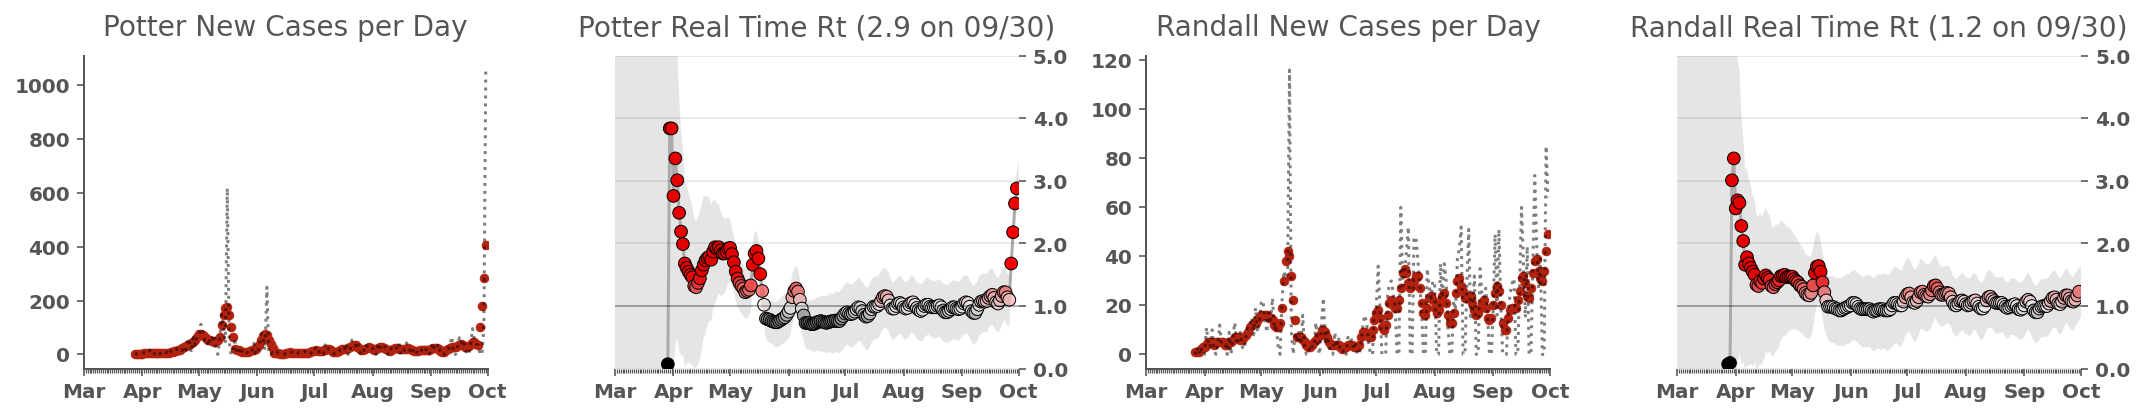

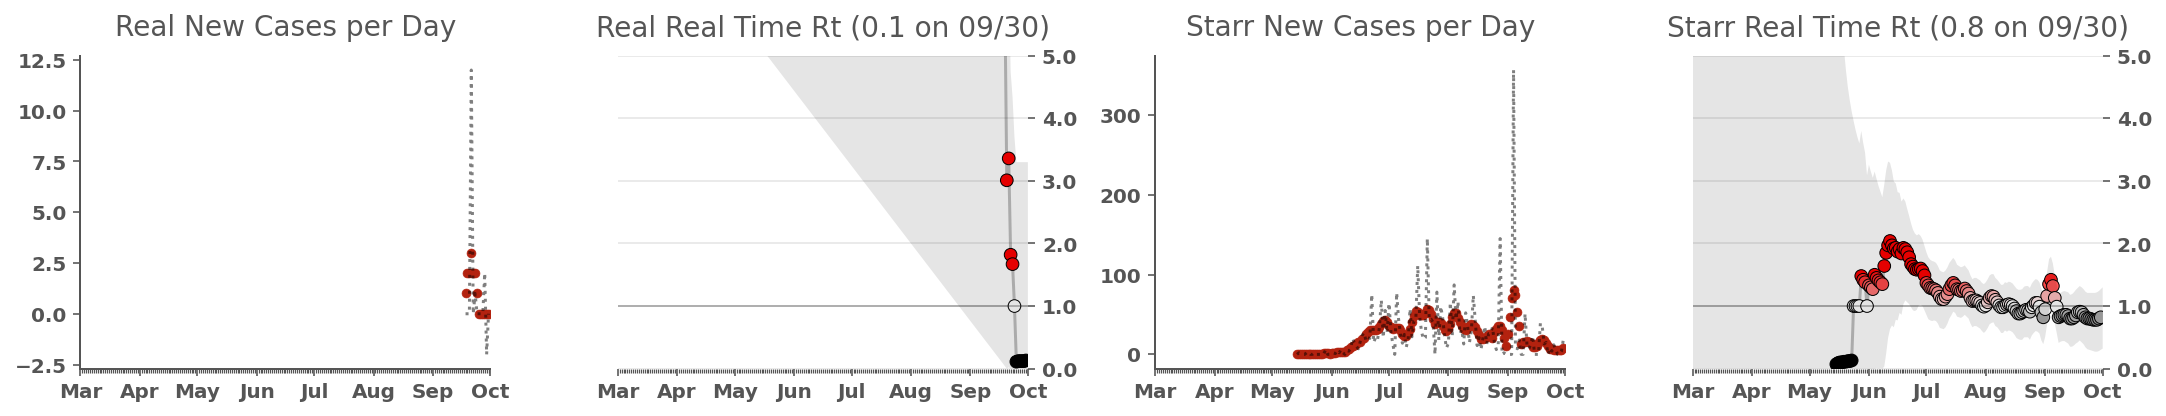

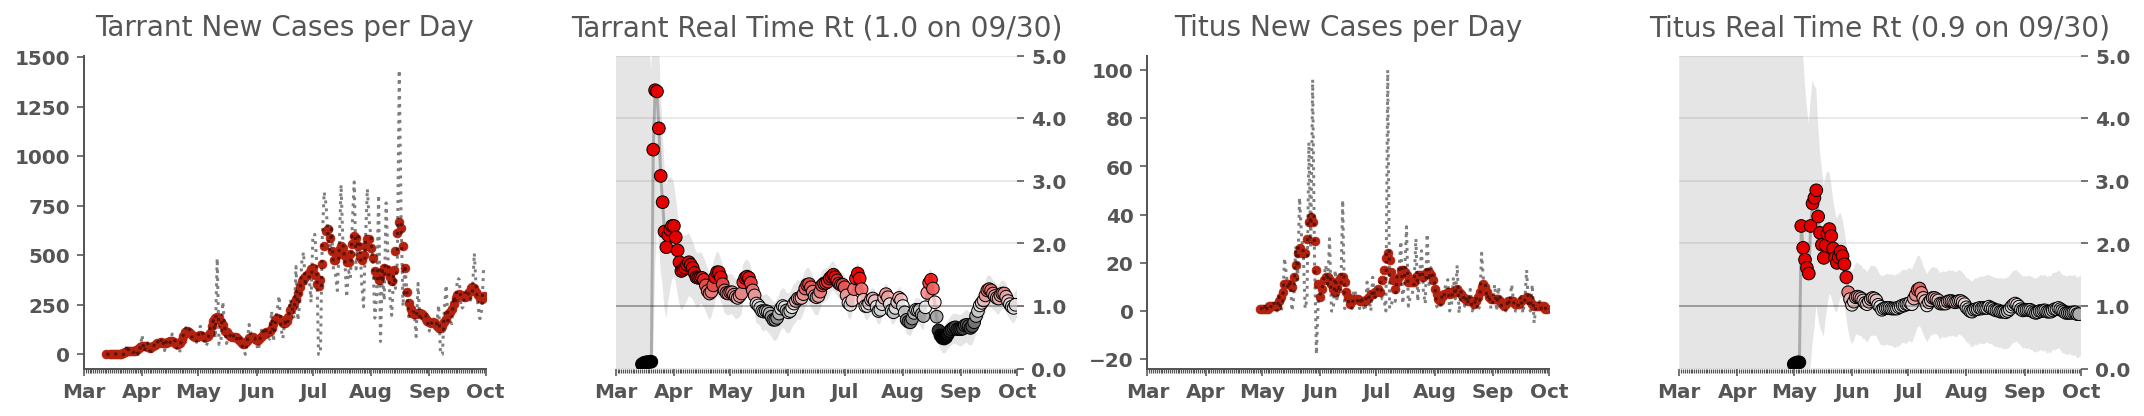

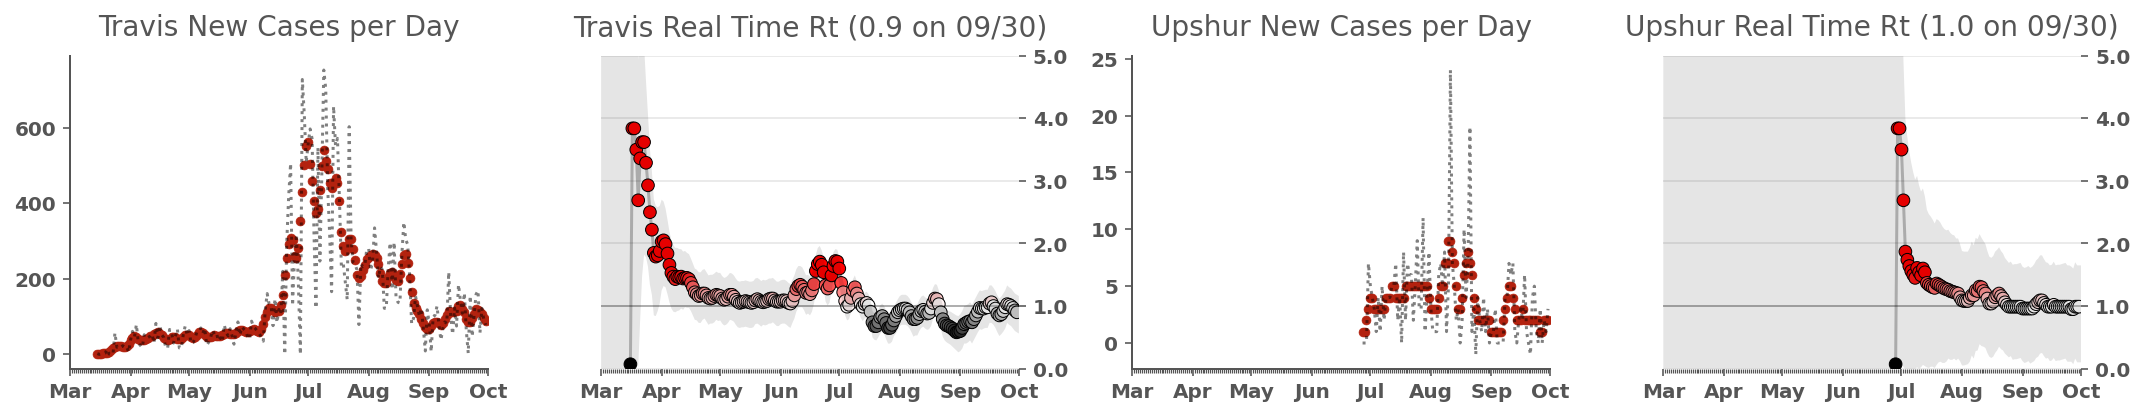

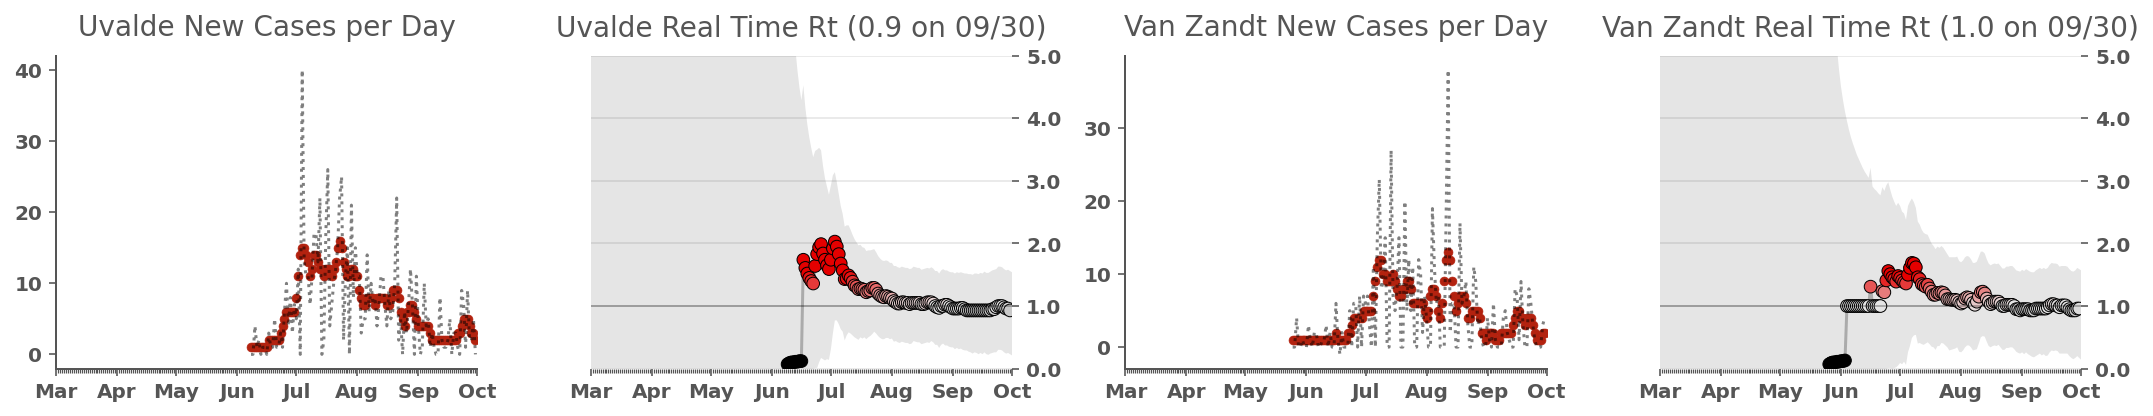

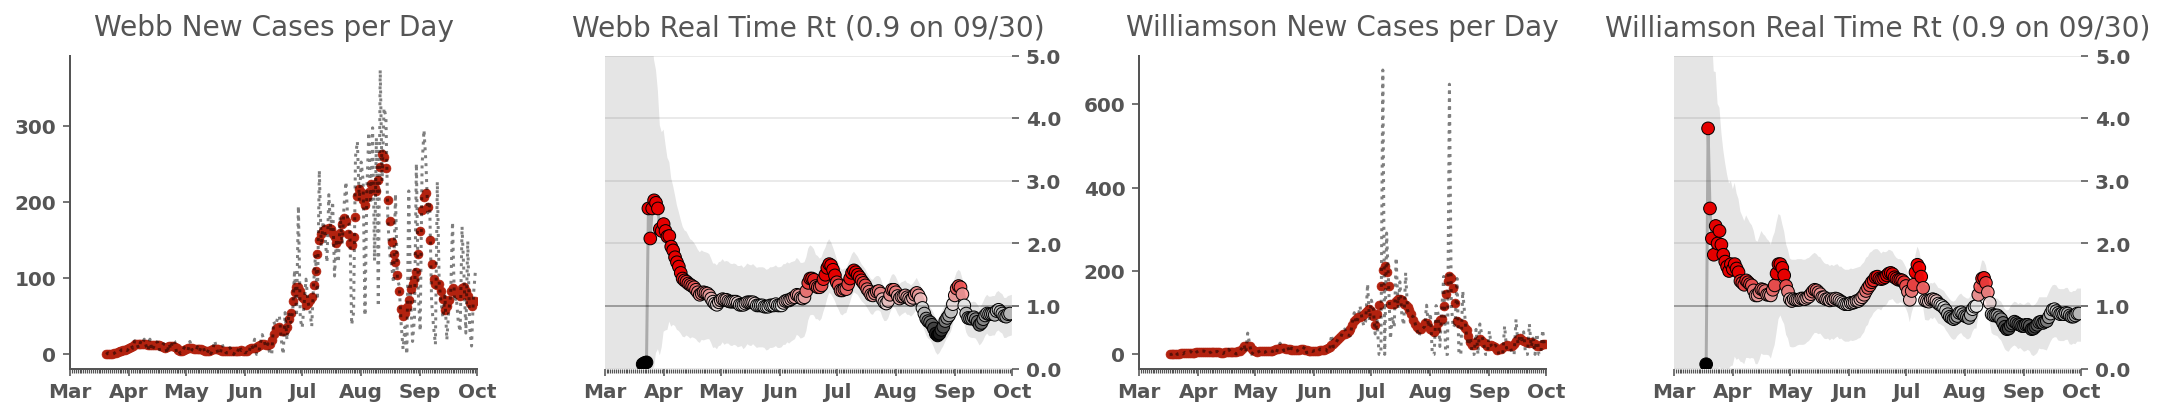

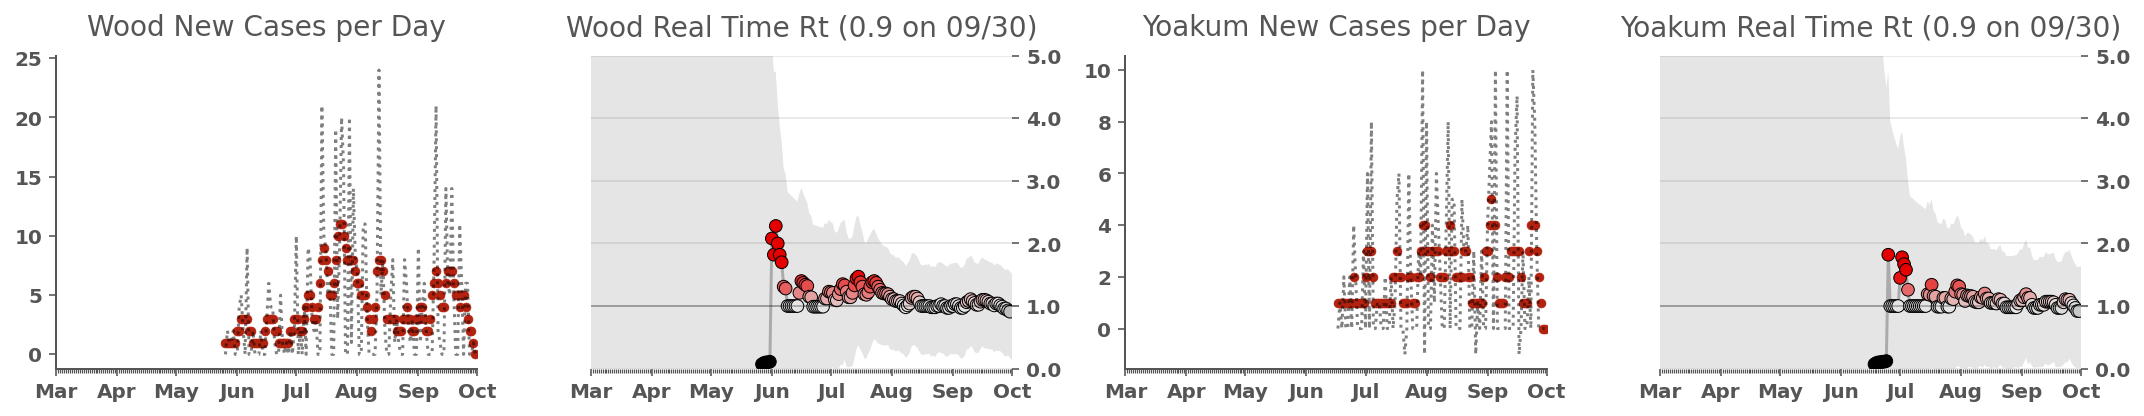

In [33]:
ncols = 4

n_valid_results = len([county_name for (county_name, result) in final_results.groupby('county') if len(result.iloc[1:]) >= 2])
        
nrows = int(np.ceil(n_valid_results * 2 / ncols))


n = 0
valid = 0
for i, (county_name, result) in enumerate(final_results.groupby('county')):
    if (len(result.iloc[1:])<2):
        n = n+1
        continue
    else:
        if valid % 2 == 0:
            fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 3))

        plot_cases(county_name, axes.flat[2*(i%2)], cutoff=1)
        plot_rt(result.iloc[1:], axes.flat[2*(i%2)+1], county_name)
        
        if valid % 2 == 1:
            fig.tight_layout()
            fig.set_facecolor('w')
            #fig.show()
            plt.show()
        valid += 1


In [34]:
# Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
final_results = final_results.groupby('county').apply(lambda x: x.iloc[1:].droplevel(0));

In [35]:
final_results

ML  Low_90  High_90  Low_50  High_50
county  date                                              
Aransas 2020-06-23  0.07    0.00     8.73    0.00     4.03
        2020-06-24  0.09    0.00     7.10    0.00     3.20
        2020-06-25  0.10    0.00     6.15    0.00     2.77
        2020-06-26  2.56    0.00     6.31    0.81     3.85
        2020-06-27  2.08    0.00     5.34    0.60     3.16
...                  ...     ...      ...     ...      ...
Yoakum  2020-09-26  1.05    0.10     1.81    0.60     1.34
        2020-09-27  1.01    0.05     1.73    0.60     1.33
        2020-09-28  0.97    0.02     1.67    0.53     1.26
        2020-09-29  0.92    0.00     1.62    0.47     1.20
        2020-09-30  0.92    0.01     1.63    0.48     1.21

[8822 rows x 5 columns]

### Export Data to CSV

In [36]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv('./TSHS_CaseCountData/rt_tx.csv')

### Most recent $R_t$ by county

In [37]:
no_lockdown = []
partial_lockdown = []

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]
#ERROR_BAR_COLOR = 'red'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


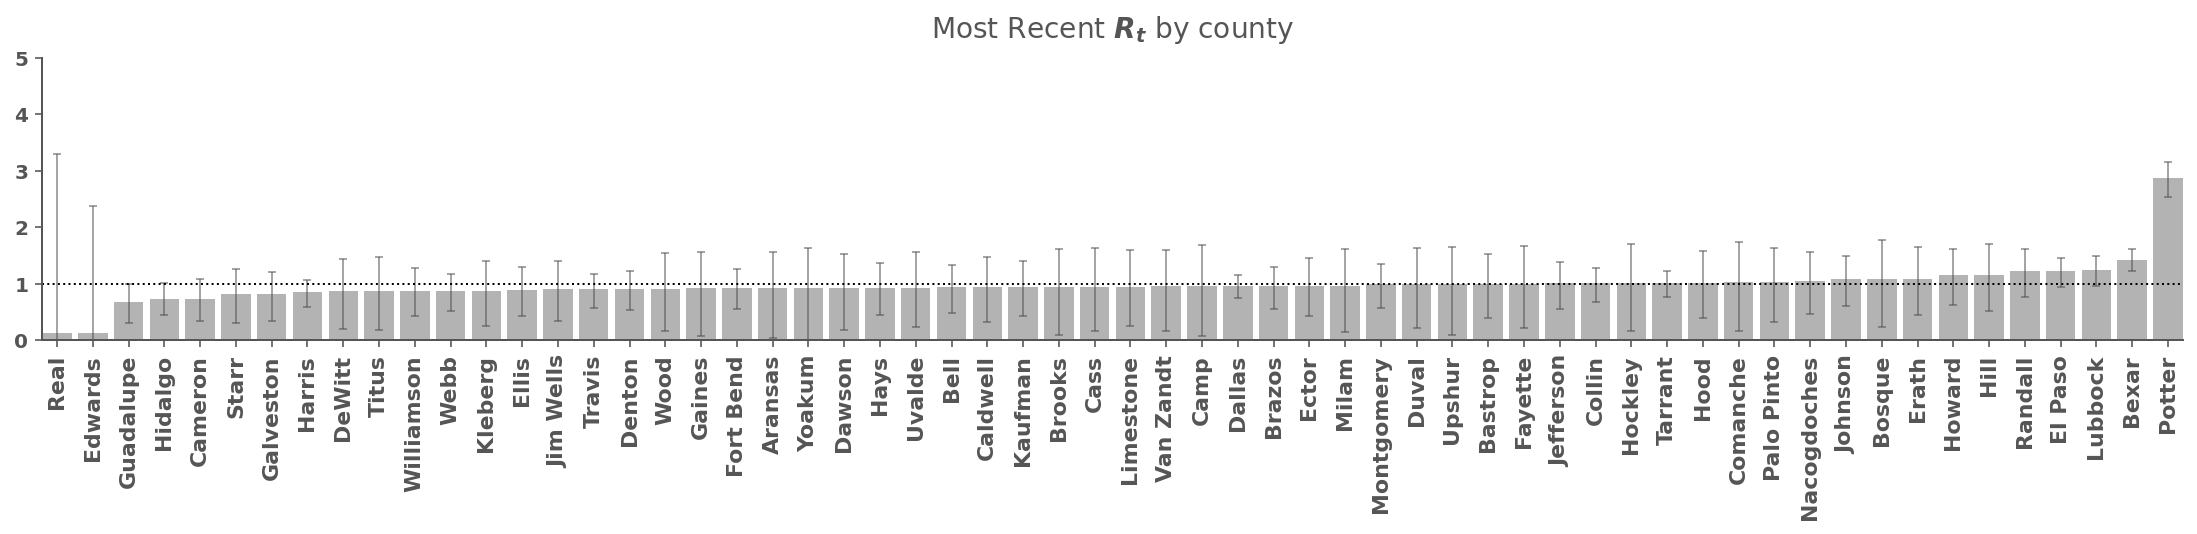

In [38]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by county'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

#     for bar, county_name in zip(bars, mr.index):
#         if county_name in no_lockdown:
#             bar.set_color(NONE_COLOR)
#         if county_name in partial_lockdown:
#             bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0, 5.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

#     leg = ax.legend(handles=[
#                         Patch(label='Full', color=FULL_COLOR),
#                         Patch(label='Partial', color=PARTIAL_COLOR),
#                         Patch(label='None', color=NONE_COLOR)
#                     ],
#                     title='Lockdown',
#                     ncol=3,
#                     loc='upper left',
#                     columnspacing=.75,
#                     handletextpad=.5,
#                     handlelength=1)

#     leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


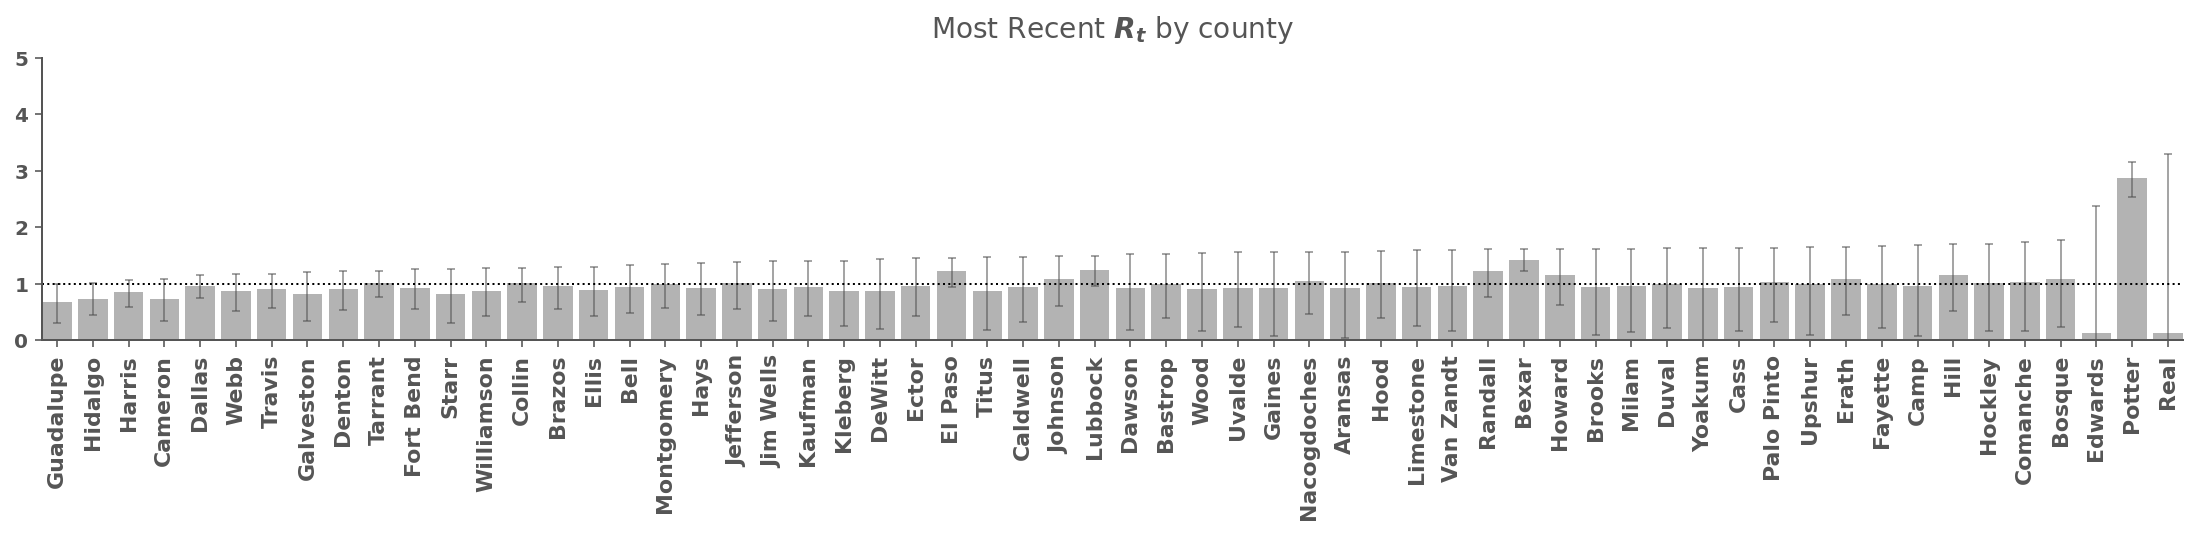

In [39]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


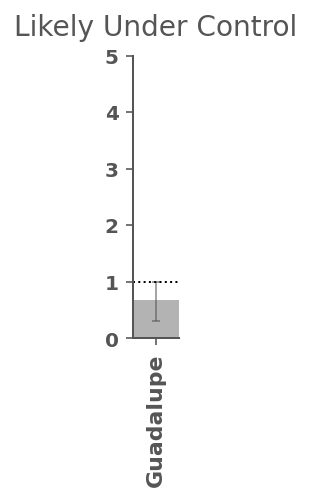

In [40]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


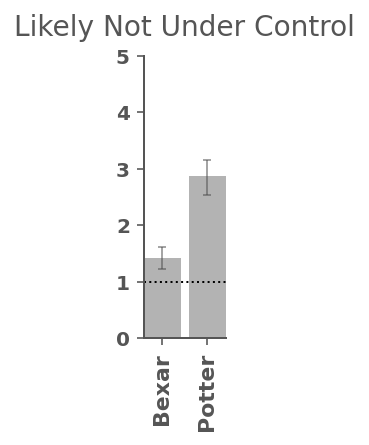

In [41]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
#ax.get_legend().remove()